# Read me

This is part of the code for my master's dissertation about **The Relation of Pupil Dynamics with Task Performance and Ongoing Fluctuations of Neuronal Activity in Superior Colliculus in Visual Detection Tasks**.

Figure 6 involves the analysis of neuronal activity and pupil size when mice were flashed with natural images. The pre-processed data can be found on **Visual Behavioral Neuropixels** on Allen Institute Platform.

For more information, please contact sallyzhang010804@gmail.com. 

All the code analysis credits to Sally (Pan) Zhang.

## Get session information from allensdk

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

# Confirming your allensdk version
print(f"Your allensdk version is: {allensdk.__version__}")

# Update this to a valid directory in the filesystem. This is where the data will be stored.
output_dir = "./ecephys_cache/"
DOWNLOAD_COMPLETE_DATASET = False

output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

/Users/zhangpan/anaconda3/envs/neuropixels/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Your allensdk version is: 2.15.2


In [2]:
def makePSTH(spikes, startTimes, windowDur, binSize=0.01):

    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for start in startTimes:
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins[:-1]



def make_neuron_time_trials_array(units, spike_times, stim_table, 
                                   time_before, trial_duration,
                                   bin_size=0.01):
    '''
    Function to make a 3D array with dimensions [neurons, time bins, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe whose indices are trial ids and containing a
            'start_time' column indicating when each trial began
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_array: 3D array storing spike counts. The value in [i,j,k] 
            is the spike count for neuron i at time bin j in the kth trial.
        time_vector: vector storing the trial timestamps for the time bins
    '''
    # Get dimensions of output array
    neuron_number = len(units)
    trial_number = len(stim_table)
    num_time_bins = int(trial_duration/bin_size)
    
    # Initialize array
    unit_array = np.zeros((neuron_number, num_time_bins, trial_number))
    
    # Loop through units and trials and store spike counts for every time bin
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        
        # grab spike times for this unit
        unit_spike_times = spike_times[iu]
        
        # now loop through trials and make a PSTH for this unit for every trial
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            trial_start = trial.start_time - time_before
            unit_array[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    
    # Make the time vector that will label the time axis
    time_vector = np.arange(num_time_bins)*bin_size - time_before
    
    return unit_array, time_vector

In [3]:
# access information about a specific ecephys session

female_session_id = [1044594870, 1055415082, 1081429294, 1086410738, 1093864136]
male_session_id = [1052533639, 1063010385, 1115368723, 1118508667]

ecephys_id = 1067790400

session = cache.get_ecephys_session(ecephys_session_id=ecephys_id)

/Users/zhangpan/anaconda3/envs/neuropixels/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.8.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/zhangpan/anaconda3/envs/neuropixels/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/zhangpan/anaconda3/envs/neuropixels/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.5.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [4]:
# get the unit and channel data for this session
units = session.get_units()
channels = session.get_channels()

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)

# Grab spike times and calculate the change response for 'good' units in V1
#first let's sort our units by depth
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = (
                    (unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1)
                    )

good_units = unit_channels.loc[good_unit_filter]
spike_times = session.spike_times

stimulus_presentations = session.stimulus_presentations
trials = session.trials

def get_change_time_from_stim_table(row):
    '''
    Given a particular row in the trials table,
    find the corresponding change time in the 
    stimulus presentations table
    '''
    table = stimulus_presentations
    change_frame = row['change_frame']
    if np.isnan(change_frame) or change_frame < 0:
        return np.nan
    
    change_time = table[table.start_frame==change_frame]\
                    ['start_time'].values[0]
    
    return change_time

change_times = trials.apply(get_change_time_from_stim_table, axis=1)
trials['change_time_with_display_delay'] = change_times

#Grab the portion of the stim table that describes the active behavior stimuli
active_presentation = stimulus_presentations[stimulus_presentations['active'] == True]
task_stim_table = active_presentation[active_presentation['is_change'] == True]

## Trial outcome

Text(0.5, 1.0, 'Mice Performance Across Trials)')

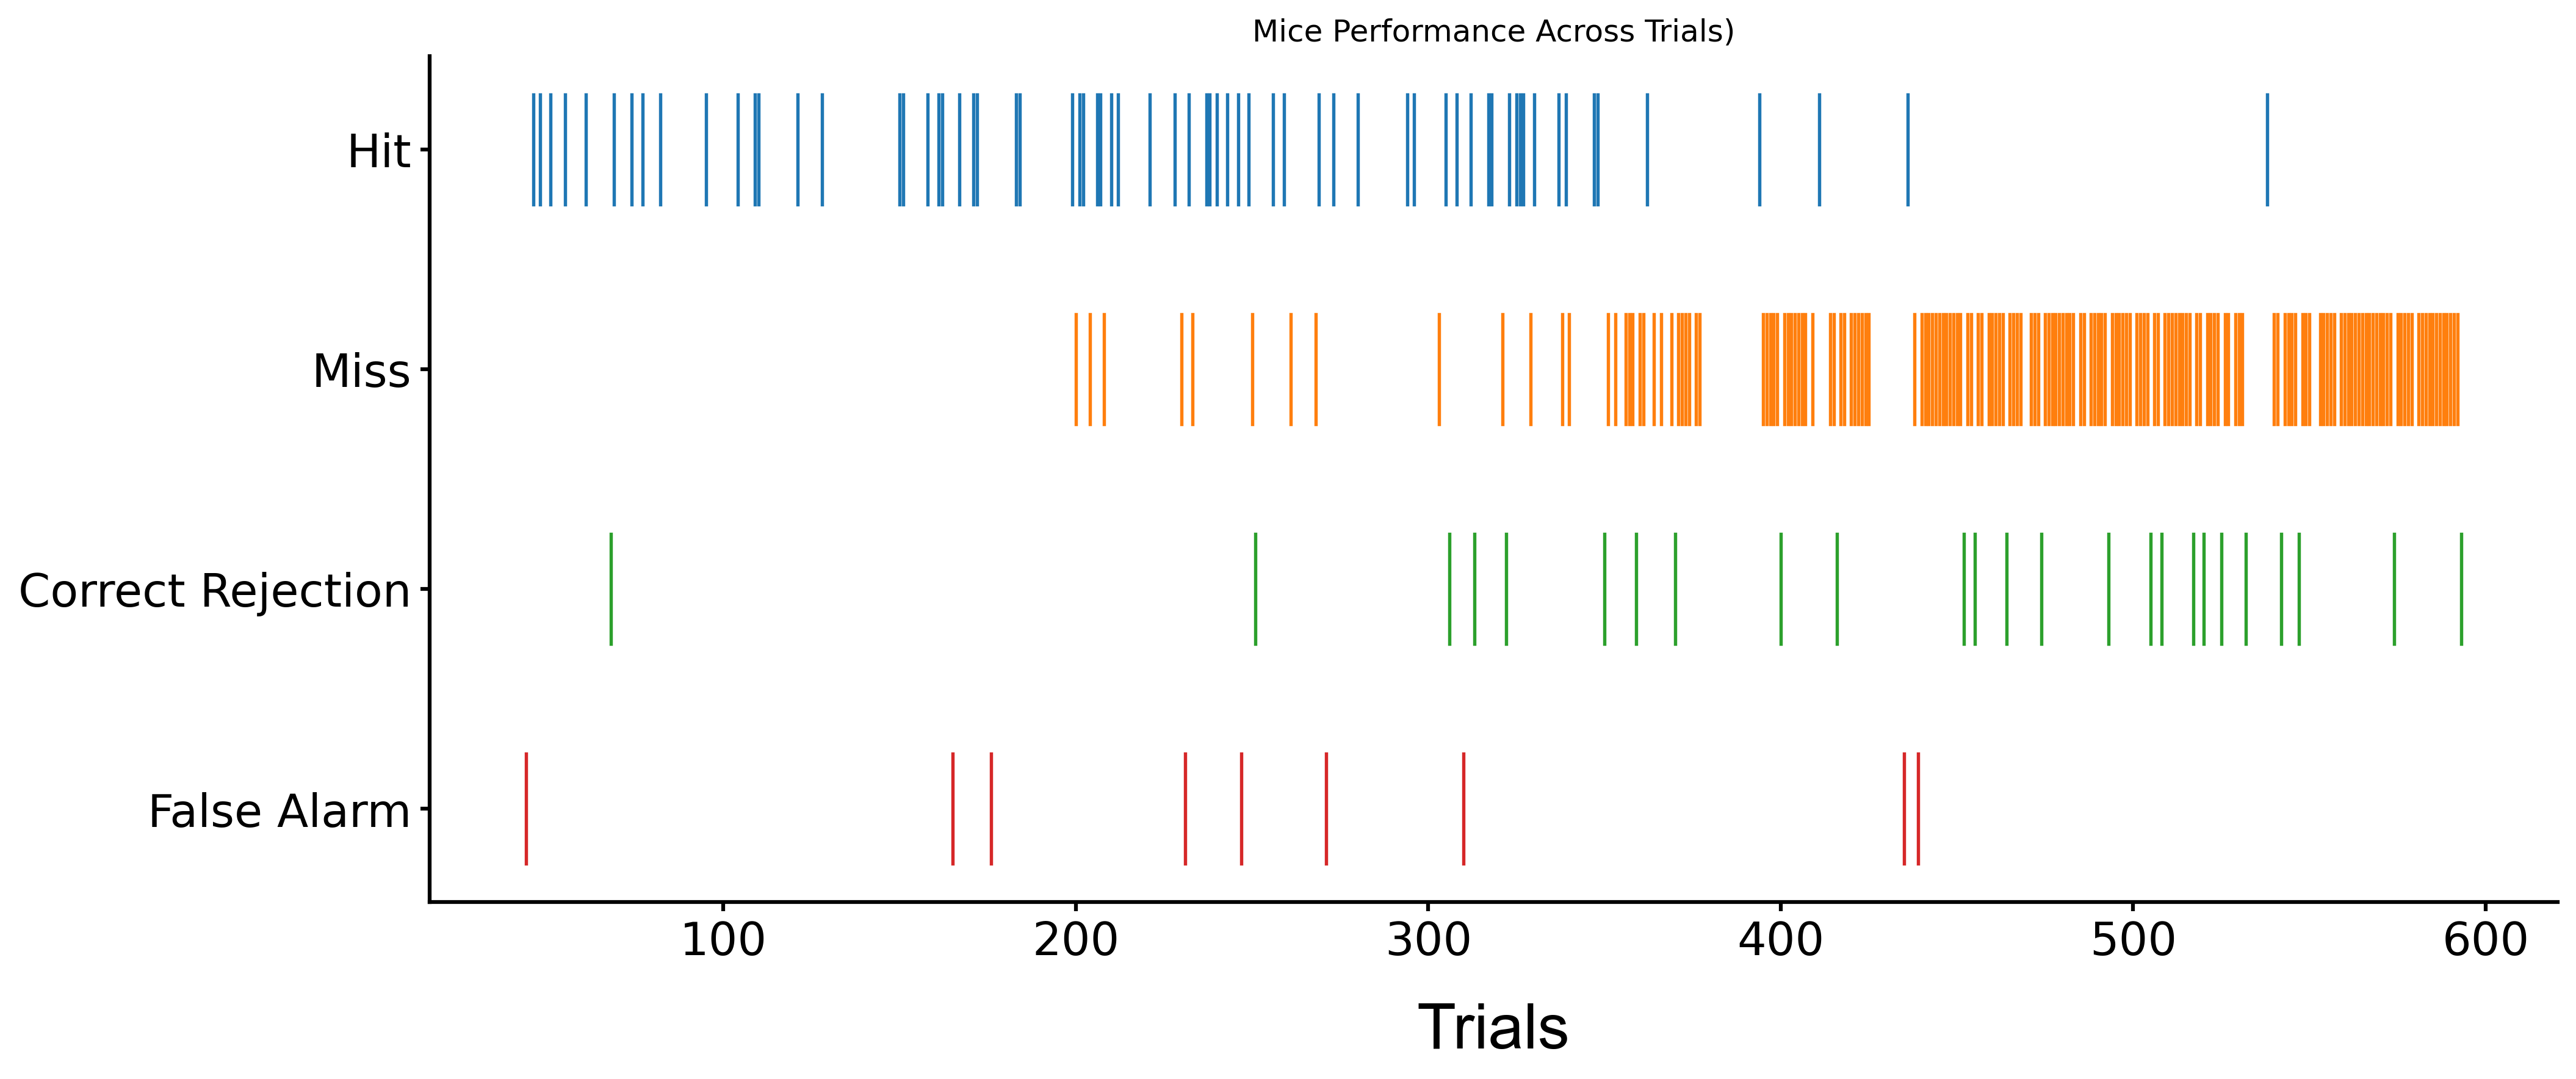

In [5]:
# Trial outcome plot
# Select only the relevant columns
selected_columns = ['hit', 'miss', 'false_alarm', 'correct_reject']

# Create a new DataFrame with only the selected columns
event_df = trials[selected_columns].copy()

# Define the colors for different events
colors = {'hit': '#1f77b4', 'miss': '#ff7f0e', 'false_alarm': '#d62728', 'correct_reject': '#2ca02c'}

# Create a figure and axis
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(15, 6)

# Set vertical offsets for each event type
# offsets = {'hit': 0, 'miss': 1, 'false_alarm': 2, 'correct_reject': 3}
offsets = {'hit': 3, 'miss': 2, 'false_alarm': 0, 'correct_reject': 1}

# Set vertical spacing between rows
row_height = 0.5

# Iterate through each event and plot events on the same subplot with different vertical offsets
for event, color in colors.items():
    for index, row in event_df.iterrows():
        if row[event]:
            ax.plot([index, index], [offsets[event] - row_height / 2, offsets[event] + row_height / 2],
                    color=color, linewidth=1.3)
            # ax.plot(index, offsets[event], marker='|', color=color, markersize=10)

# Set labels and title
ax.tick_params(axis='x', labelsize=18, width=1.5)
ax.tick_params(axis='y', labelsize=18, width=1.5)
ax.set_xlabel('Trials', labelpad=15, size=25, fontweight=1.5, family='Arial')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)  # Adjust the width as needed
ax.spines['left'].set_linewidth(1.5)

# ax.set_xlim(0, 160)
Trial_type = ['Hit', 'Miss', 'False Alarm', 'Correct Rejection']
ax.set_yticks(list(offsets.values()))
ax.set_yticklabels(Trial_type)
ax.set_title(f'Mice Performance Across Trials)')

## PSTH

In [6]:
# Get unit_array: 3D array storing spike counts. 
# The value in [i,j,k] is the spike count for neuron i at time bin j in the kth trial.
area_of_interest = 'SCig'
area_units = good_units[good_units['structure_acronym']==area_of_interest]

# 250ms before vstim
time_before_change = 0.25
duration = 0.5

bin_size = 0.01
trial_area_response_array, time = make_neuron_time_trials_array(area_units, spike_times,
                                                       task_stim_table, time_before_change, 
                                                       duration)
# all trial response fr
area_change_responses = []
for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]
    unit_change_response, bins = makePSTH(unit_spike_times, 
                                          change_times-time_before_change, 
                                          duration, binSize=0.01)
    area_change_responses.append(unit_change_response) 
area_change_responses = np.array(area_change_responses)

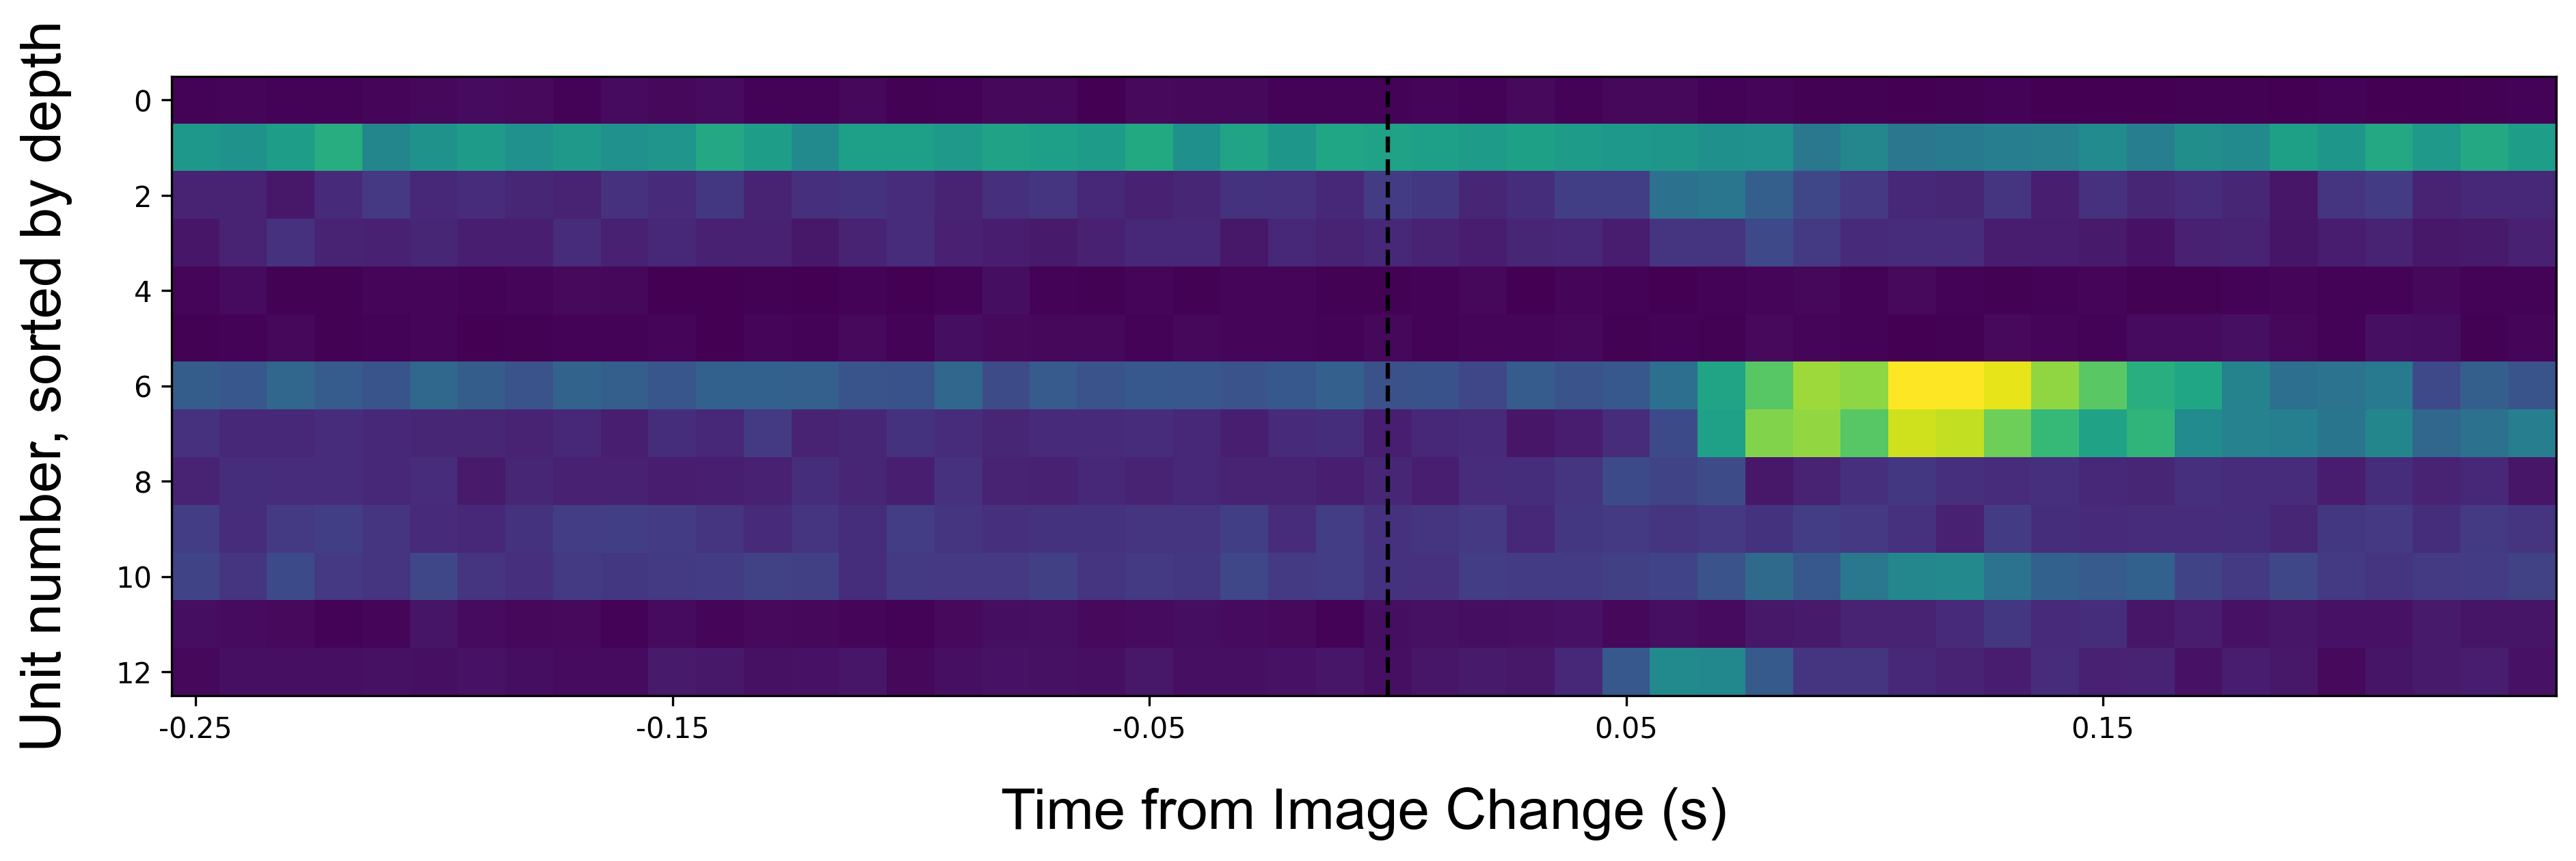

In [7]:
#Here's where we loop through the units in our area of interest and compute their PSTHs

fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(15, 6)

clims = [np.percentile(area_change_responses, p) for p in (0.1,99.9)]
im = ax.imshow(area_change_responses, clim=clims)

# ax.set_title('Active change response in {} unit population'.format(area_of_interest))
ax.set_ylabel('Unit number, sorted by depth', labelpad=15, size=20, fontweight=1.5, family='Arial')
ax.set_xlabel('Time from Image Change (s)', labelpad=15, size=20, fontweight=1.5, family='Arial')
ax.set_xticks(np.arange(0, bins.size, 10))
_ = ax.set_xticklabels(np.round(bins[:-1:10]-time_before_change, 2))

ax.axvline(x=25, color='black', linestyle='--') # Vstim onset with delay
# ax.tick_params(axis='x', labelsize=18, width=1.5)
# ax.tick_params(axis='y', labelsize=18, width=1.5)


mean_pre_stim is 9.548392181588902
mean_stim is 14.255989911727617


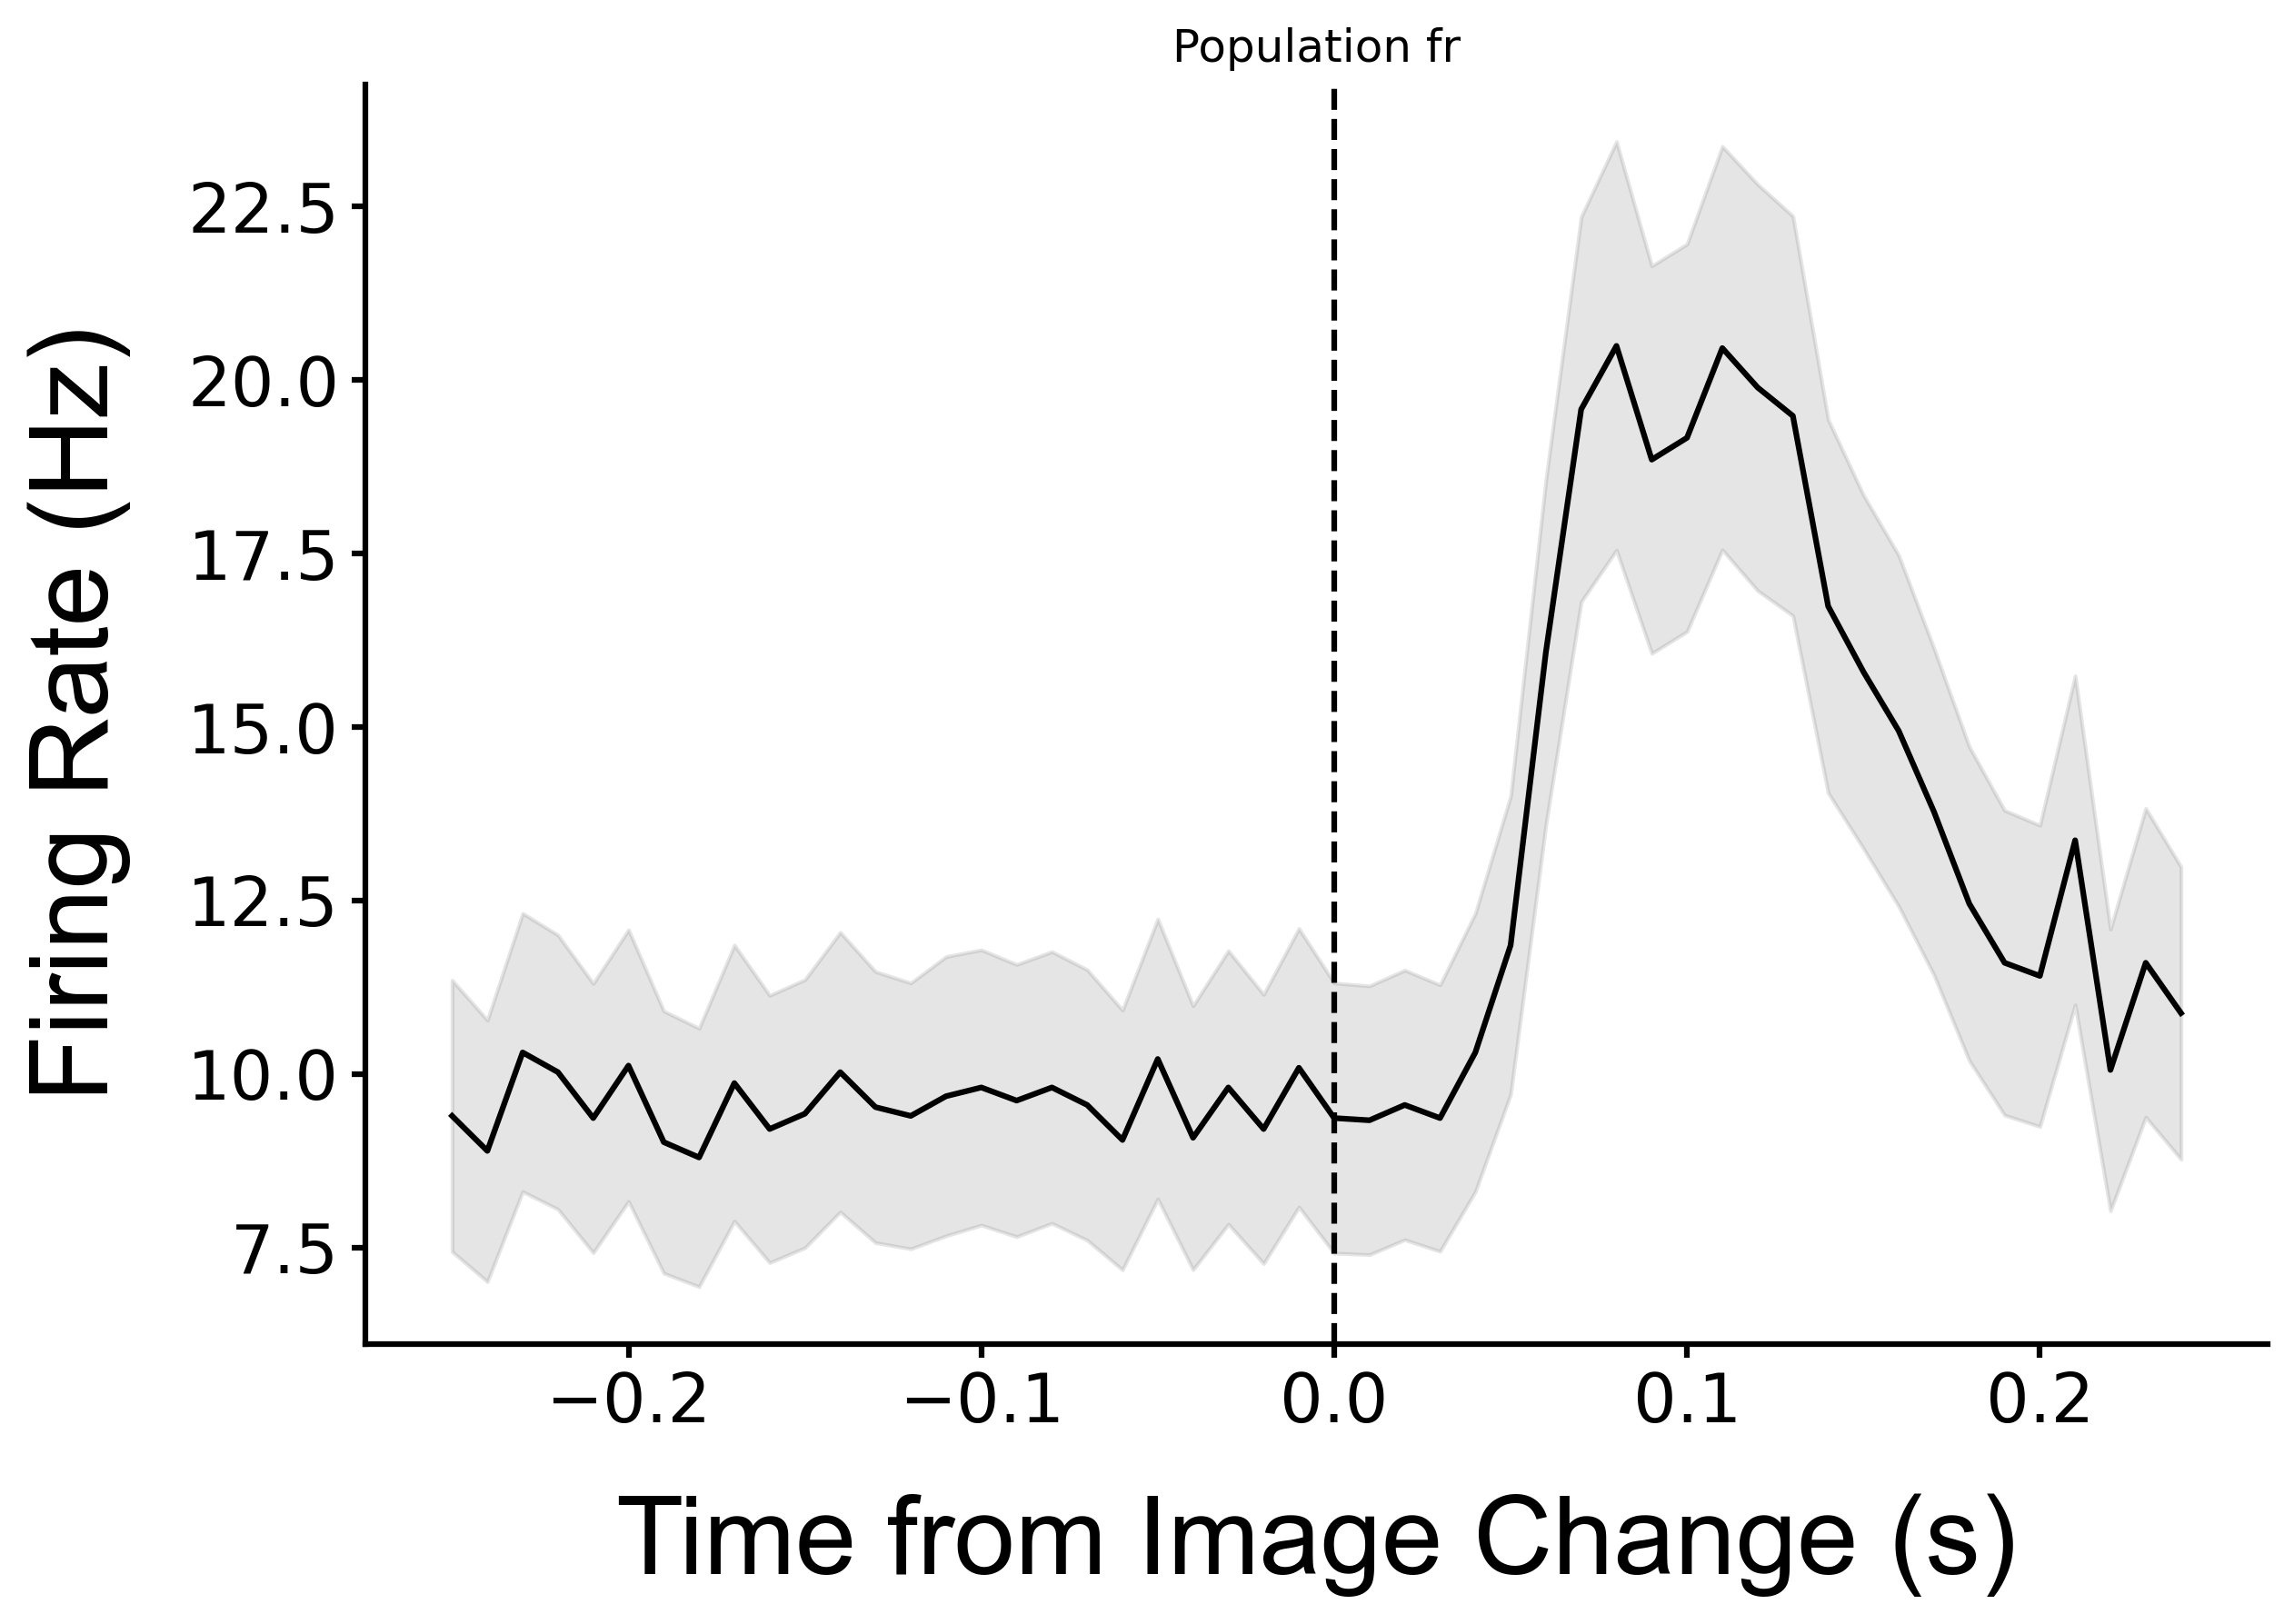

In [8]:
# Calculate mean and std for the population firing rate
mean_population_fr = np.mean(trial_area_response_array, axis=(0, 2))

mean_normalized_population_fr = np.mean(trial_area_response_array, axis=(0, 2))
std_normalized_population_fr = np.std(trial_area_response_array, axis=(0, 2))
sem_normalized_population_fr = std_normalized_population_fr / np.sqrt(trial_area_response_array.shape[2])


# Plot population data
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(9,6)

ax.plot(time, mean_normalized_population_fr, color='black', label='Mean Normalized Population FR')
ax.fill_between(time, mean_normalized_population_fr - sem_normalized_population_fr, 
                mean_normalized_population_fr + sem_normalized_population_fr, color='grey', alpha=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)  # Adjust the width as needed
ax.spines['left'].set_linewidth(1.5)
ax.axvline(x=0, color='black', linestyle='--') # Vstim onset with delay
ax.set_title(f'Population fr')
ax.set_ylabel('Firing Rate (Hz)', labelpad=15, size=29, fontweight=1.5, family='Arial')
ax.set_xlabel('Time from Image Change (s)', labelpad=15, size=29, fontweight=1.5, family='Arial')
ax.tick_params(axis='x', labelsize=18, width=1.5)
ax.tick_params(axis='y', labelsize=18, width=1.5)
ax.legend

# Calculate means for pre-stimulus and stimulus periods
mean_pre_stim = np.mean(mean_normalized_population_fr[0:24])
mean_stim = np.mean(mean_normalized_population_fr[25:])

print(f'mean_pre_stim is {mean_pre_stim}')
print(f'mean_stim is {mean_stim}')

## Population Firing Rate pre-Vstim vs Vstim

In [3]:
group_id = [1067790400,  1044594870, 1055415082,1081429294, 1086410738,   1093864136,  1063010385, 1115368723,]
group_pre_stim = [9.548392181588902, 4.357789855072464, 5.995311618725324, 8.897202660406885, 18.444300797241976,   11.769393241167435, 7.6077147016011635,  ]
group_stim = [14.255989911727617,  6.3191304347826085, 8.446700507614214, 11.317840375586856, 17.04632622279681,    11.348387096774193, 7.871441048034935, ]

In [4]:
# Plotting Pre vs stim
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(6, 9)

# Organize data for box plot
data = [group_pre_stim, group_stim]
positions = [1, 2]
bp = ax.boxplot(data, positions=positions, widths=0.2, patch_artist=True, medianprops=dict(color='black'), zorder=1)

# Set colors for the boxes
colors = ['#7fbfff', '#D0F0C0']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Plot paired dots and connect them
for before, after in zip(group_pre_stim, group_stim):
    ax.plot(positions, [before, after], marker='o', linestyle='-', color='gray', linewidth=1, zorder=2)

# Customize the plot
# ax.set_title('All trials before vs after Vstim')
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('', labelpad=10, size=30, family='Arial')
ax.set_ylabel('Firing rate (Hz)', labelpad=20, size=30, family='Arial')
ax.set_xticks(positions)
ax.set_xticklabels(['Pre-Vstim', 'Vstim'], size=20, family='Arial')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.text(0.05, 0.95, f'n = {len(group_pre_stim)}', fontsize=13, ha='left', va='top', transform=ax.transAxes)

plt.show()



NameError: name 'plt' is not defined

In [ ]:
from scipy.stats import wilcoxon

mean_group_hit = np.mean(group_pre_stim)
mean_group_miss = np.mean(group_stim)

std_group_hit = np.std(group_pre_stim)
std_group_miss = np.std(group_stim)


sem_group_hit= std_group_hit / np.sqrt(7)
sem_group_miss = std_group_miss / np.sqrt(7)


print(f'mean_group_hit is {mean_group_hit}')
print(f'mean_group_miss is {mean_group_miss}')

# print(f'std group before is {std_group_before}')
# print(f'std_group_after is {std_group_after}')

print(f'sem_group_hit is {sem_group_hit}')
print(f'sem_group_miss is {sem_group_miss}')

# Perform the Wilcoxon signed-rank test on the normalized data
stat, p_value = wilcoxon(group_pre_stim, group_stim)

# Output the test result
print(f'Wilcoxon signed-rank test statistic: {stat}, p-value: {p_value}')

mean_group_hit is 9.51715786511488
mean_group_miss is 10.94368794247389
sem_group_hit is 1.6151086246346102
sem_group_miss is 1.321544312590397
Wilcoxon signed-rank test statistic: 5.0, p-value: 0.15625


# Hit vs Miss Firing Rate

mean_hit is 5.338691159586678
mean_miss is 11.247421161214264


/var/folders/48/5d2p83yj3zqbry1wm4glp6p40000gn/T/ipykernel_17265/618240272.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_stim_table['Hit'] = task_stim_table['trials_id'].isin(hit_trial_id)
/var/folders/48/5d2p83yj3zqbry1wm4glp6p40000gn/T/ipykernel_17265/618240272.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_stim_table['Miss'] = task_stim_table['trials_id'].isin(miss_trial_id)


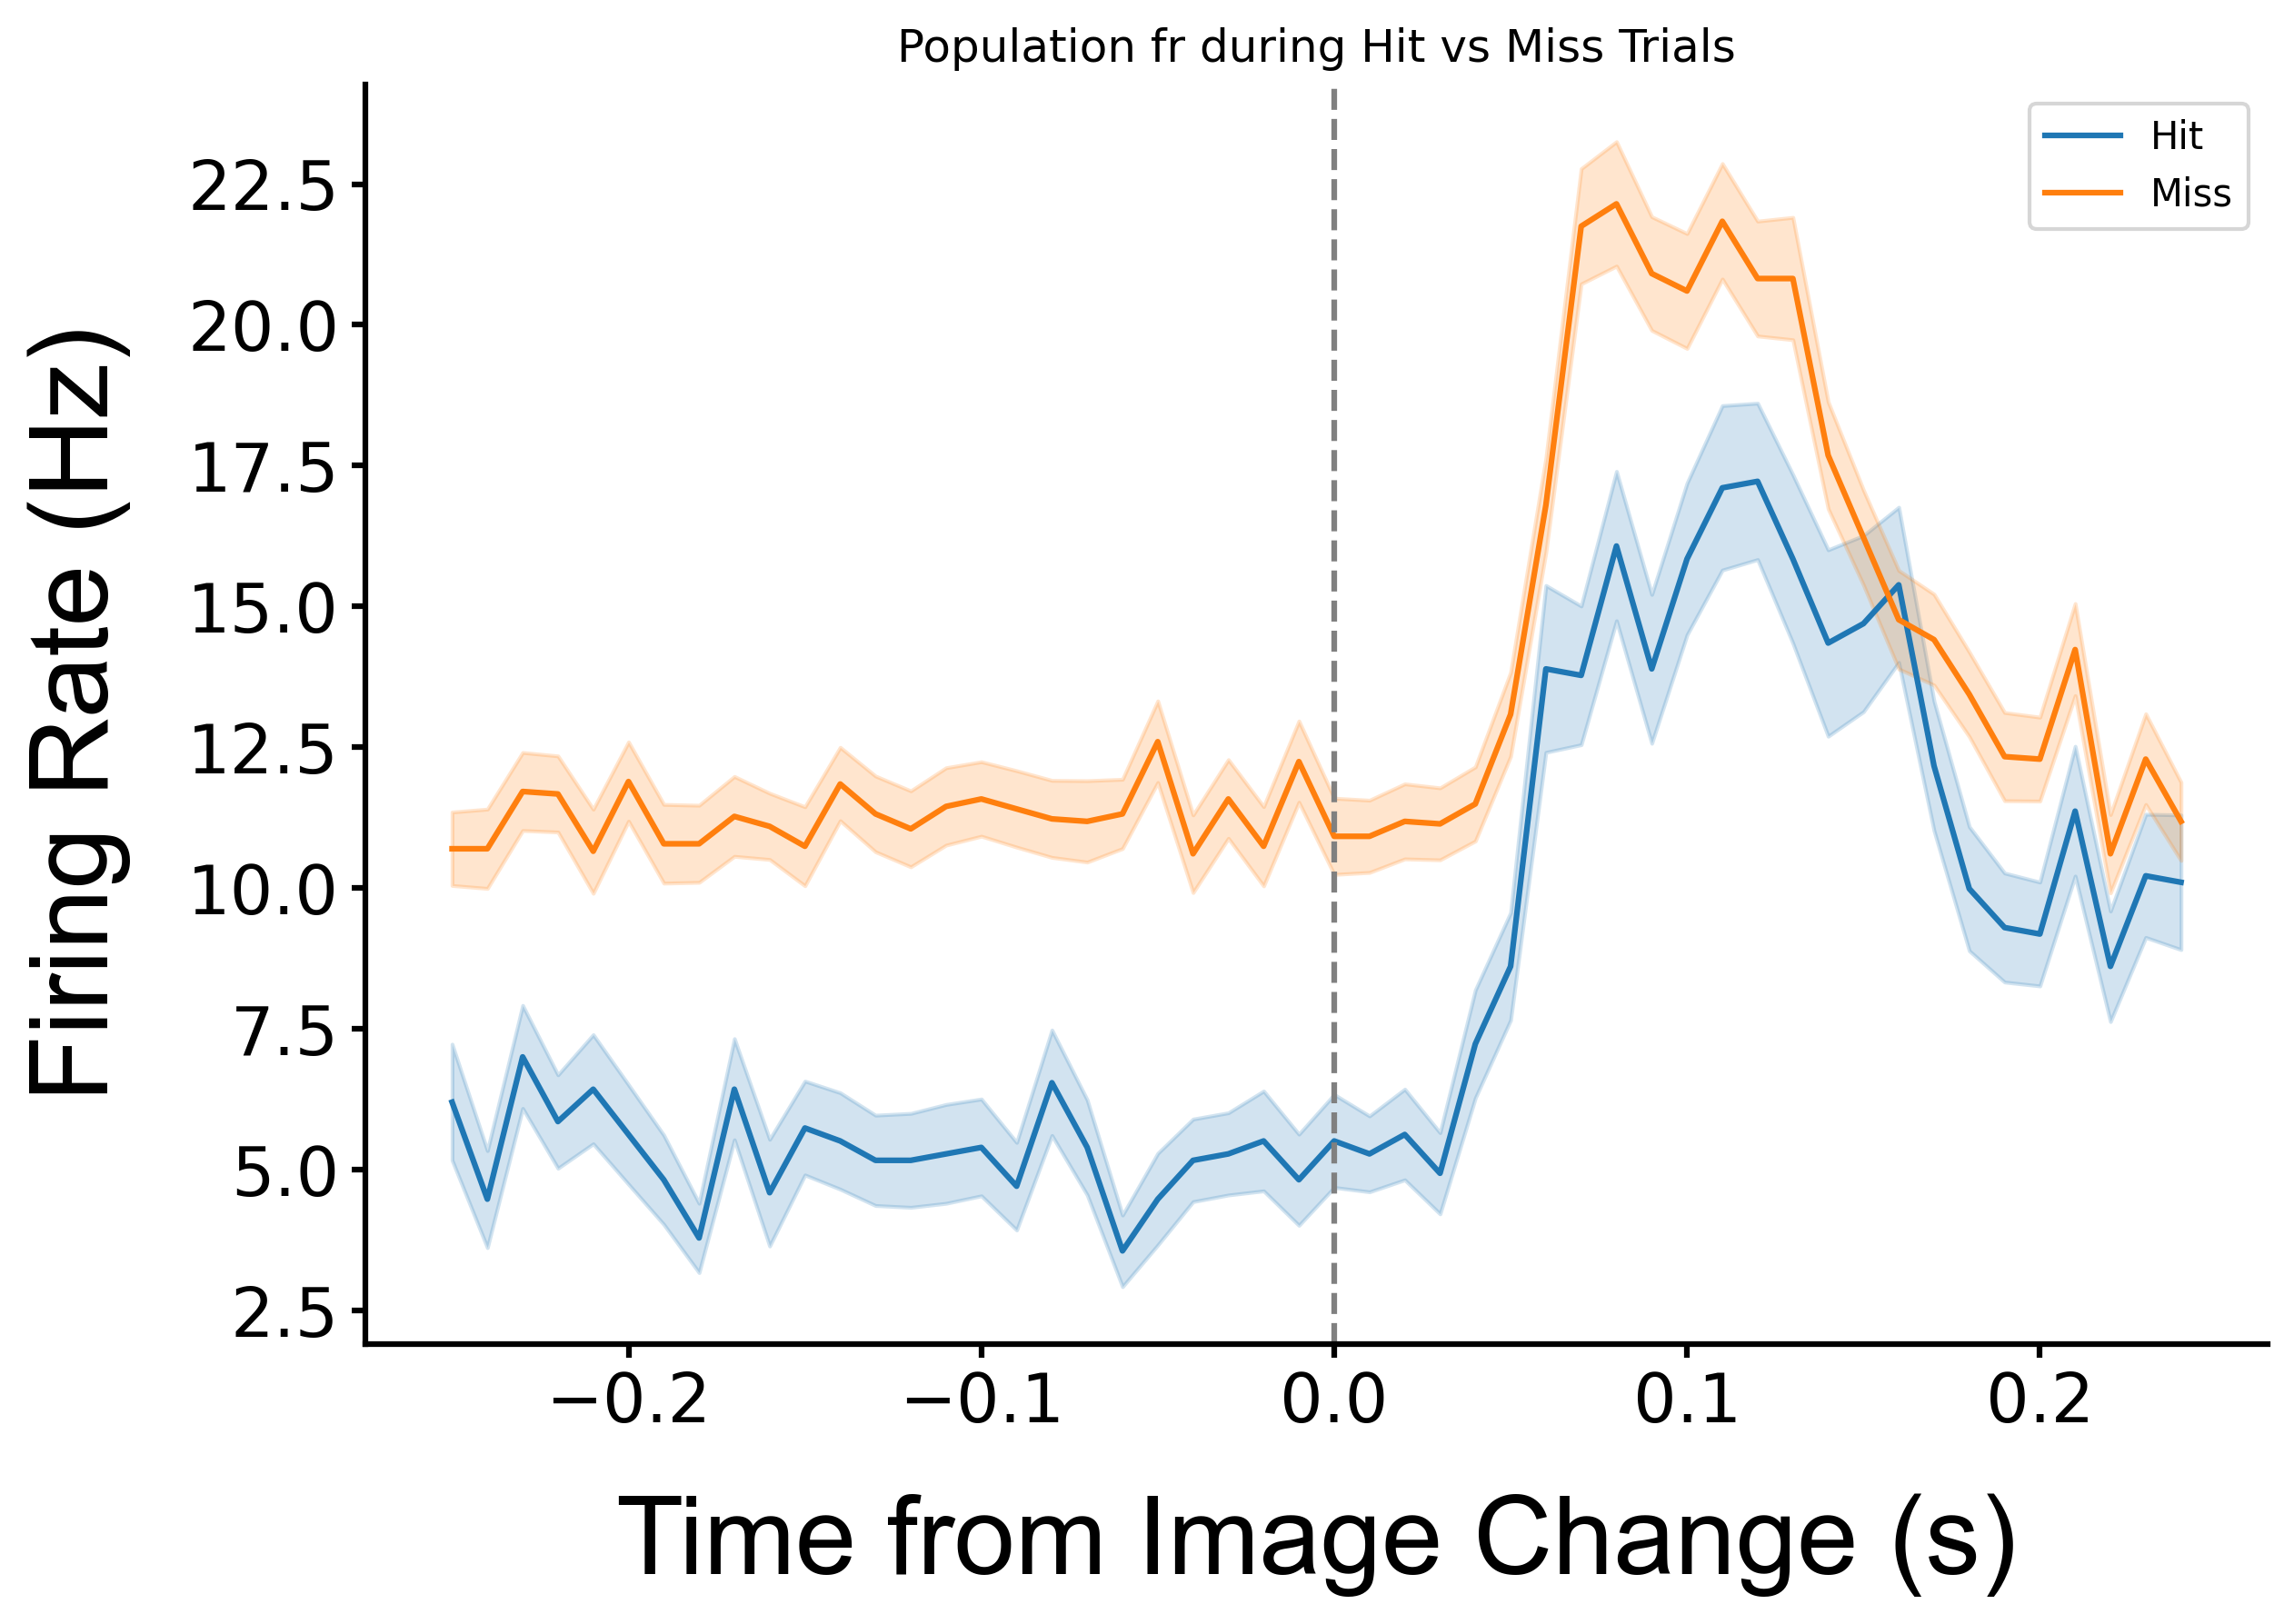

In [13]:
# Hit vs Miss population 
hit_trials = trials[trials['hit']]
miss_trials = trials[trials['miss']]

# Find the trial id for all trial types
hit_trial_id = hit_trials.index.values
miss_trial_id = miss_trials.index.values

# Add hit/miss trial in task_stim_table
task_stim_table['Hit'] = task_stim_table['trials_id'].isin(hit_trial_id)
task_stim_table['Miss'] = task_stim_table['trials_id'].isin(miss_trial_id)

# Find the hit/miss trial dataframe
hit_stim_table = task_stim_table[task_stim_table['Hit'] == True]
miss_stim_table = task_stim_table[task_stim_table['Miss'] == True]

# Find indices for hit/miss/FA/CR trial in our 3D array
hit_stim_ids = hit_stim_table.index.values
hit_array_indices = task_stim_table.index.get_indexer(hit_stim_ids)

miss_stim_ids = miss_stim_table.index.values
miss_array_indices = task_stim_table.index.get_indexer(miss_stim_ids)


# Population activity in hit/miss
# (fr, trial)
hit_trials_fring_rate = []

# Loop through our hit trial indices
for hit_id in hit_array_indices:
    
    # Use these indices to select the hit trials from our data array
    relevant_trials = trial_area_response_array[:, :, hit_id]
    
    # Get the mean population fr in all trials (average across unit) 
    mean_unit_trials = np.mean(relevant_trials, axis=(0))
    hit_trials_fring_rate.append(mean_unit_trials)


# Convert to numpy array
hit_trials_firing_rate = np.array(hit_trials_fring_rate)

# Initialize lists to hold firing rates for miss trials
miss_trials_firing_rate = []

for miss_id in miss_array_indices:
    relevant_trials = trial_area_response_array[:, :, miss_id]
    mean_unit_trials = np.mean(relevant_trials, axis=0)
    miss_trials_firing_rate.append(mean_unit_trials)

# Convert to numpy array
miss_trials_firing_rate = np.array(miss_trials_firing_rate)

# Normalize the firing rates
# max_fr = np.max([np.max(hit_trials_firing_rate), np.max(miss_trials_firing_rate)])
# normalised_hit_trials_firing_rate = hit_trials_firing_rate / max_fr
# normalised_miss_trials_firing_rate = miss_trials_firing_rate / max_fr

mean_hit_firing_rate = np.mean(hit_trials_firing_rate, axis=0)
sem_hit_firing_rate = np.std(hit_trials_firing_rate, axis=0) / np.sqrt(hit_trials_firing_rate.shape[0])

mean_miss_firing_rate = np.mean(miss_trials_firing_rate, axis=0)
sem_miss_firing_rate = np.std(miss_trials_firing_rate, axis=0) / np.sqrt(miss_trials_firing_rate.shape[0])


# Plot population data
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(9,6)

# Plot hit data with SEM
ax.plot(time, mean_hit_firing_rate, label='Hit', color='#1f77b4')
ax.fill_between(time, mean_hit_firing_rate - sem_hit_firing_rate, mean_hit_firing_rate + sem_hit_firing_rate, color='#1f77b4', alpha=0.2)

# Plot miss data with SEM
ax.plot(time, mean_miss_firing_rate, label='Miss', color='#ff7f0e')
ax.fill_between(time, mean_miss_firing_rate - sem_miss_firing_rate, mean_miss_firing_rate + sem_miss_firing_rate, color='#ff7f0e', alpha=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)  # Adjust the width as needed
ax.spines['left'].set_linewidth(1.5)

# ax.set_ylim(2,2.6)
# ax.set_ylim(0.9,1.01)

ax.axvline(x=0, color='grey', linestyle='--') # Vstim onset with delay
ax.set_title(f'Population fr during Hit vs Miss Trials')
ax.set_ylabel('Firing Rate (Hz)', labelpad=15, size=29, fontweight=1.5, family='Arial')
ax.set_xlabel('Time from Image Change (s)', labelpad=15, size=29, fontweight=1.5, family='Arial')
ax.tick_params(axis='x', labelsize=18, width=1.5)
ax.tick_params(axis='y', labelsize=18, width=1.5)
ax.legend()

# ax.text(0.05, 0.95, f'n = 9', fontsize=13, ha='left', va='top', transform=ax.transAxes)

# Calculate means for pre-stimulus hit and miss
mean_hit = np.mean(mean_hit_firing_rate[0:24])
mean_miss = np.mean(mean_miss_firing_rate[0:24])

print(f'mean_hit is {mean_hit}')
print(f'mean_miss is {mean_miss}')

In [14]:
from scipy.stats import wilcoxon

# Perform the Wilcoxon signed-rank test on the normalized data
stat, p_value = wilcoxon(mean_hit_firing_rate, mean_miss_firing_rate)

# Output the test result
print(f'Wilcoxon signed-rank test statistic: {stat}, p-value: {p_value}')

Wilcoxon signed-rank test statistic: 1.0, p-value: 3.552713678800501e-15


In [15]:
means_hit = [5.338691159586678, 4.138434029738377, 5.906961178045516, 8.92454954954955, 18.060576185781603, 7.342650103519669, 4.201672424623116]
means_miss = [11.247421161214264,4.512379227053138, 6.5879216269841265, 8.854166666666666, 19.1445809092868,  8.271794871794873, 4.438849146586345]

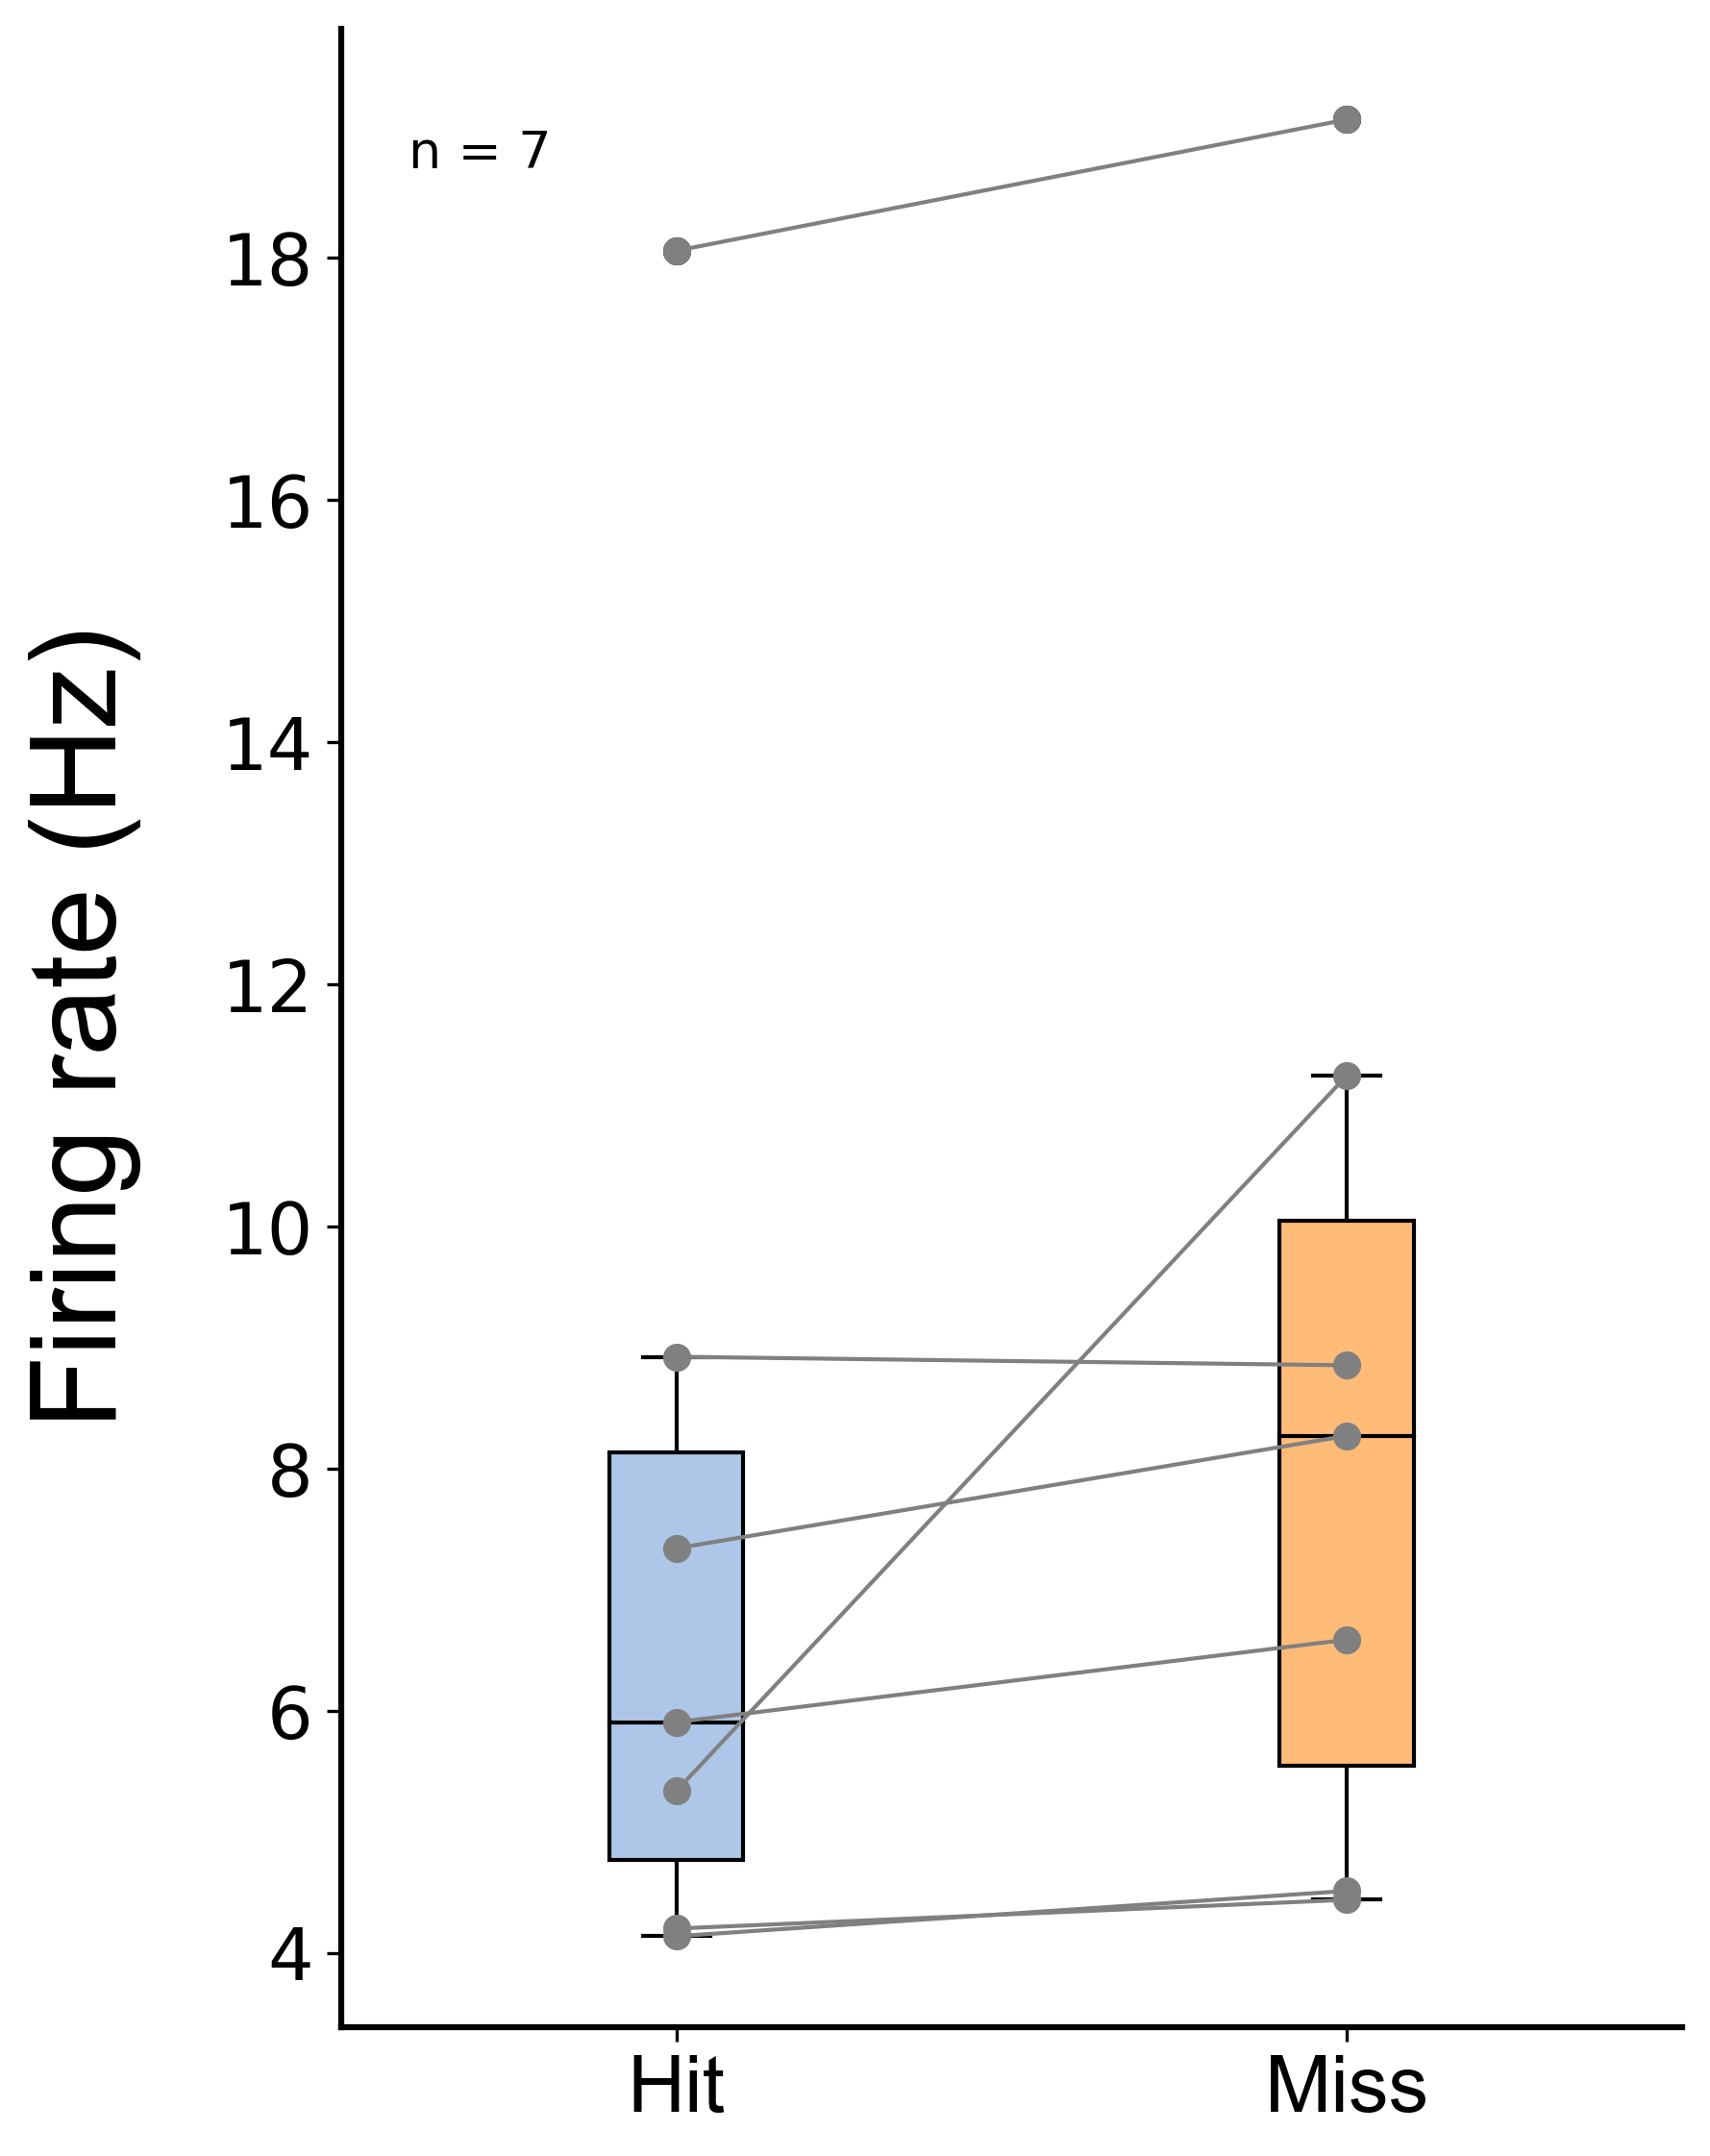

means_hit [5.338691159586678, 4.138434029738377, 5.906961178045516, 8.92454954954955, 18.060576185781603, 7.342650103519669, 4.201672424623116]
means_miss [11.247421161214264, 4.512379227053138, 6.5879216269841265, 8.854166666666666, 19.1445809092868, 8.271794871794873, 4.438849146586345]


In [17]:
# Plotting Hit vs Miss
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(6, 9)

# Organize data for box plot
data = [means_hit, means_miss]
positions = [1, 2]
bp = ax.boxplot(data, positions=positions, widths=0.2, patch_artist=True, medianprops=dict(color='black'), zorder=1)

# Set colors for the boxes
colors = ['#aec7e8','#ffbb78']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Plot paired dots and connect them
for before, after in zip(means_hit, means_miss):
    ax.plot(positions, [before, after], marker='o', linestyle='-', color='gray', linewidth=1, zorder=2)

# Customize the plot
# ax.set_title('All trials Hit vs Miss')
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('', labelpad=10, size=30, family='Arial')
ax.set_ylabel('Firing rate (Hz)', labelpad=20, size=30, family='Arial')
ax.set_xticks(positions)
ax.set_xticklabels(['Hit', 'Miss'], size=20, family='Arial')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.text(0.05, 0.95, f'n = {len(means_hit)}', fontsize=13, ha='left', va='top', transform=ax.transAxes)

plt.show()

print(f'means_hit {means_hit}')
print(f'means_miss {means_miss}')

In [18]:
from scipy.stats import wilcoxon

mean_group_hit = np.mean(means_hit)
mean_group_miss = np.mean(means_miss)

std_group_hit = np.std(means_hit)
std_group_miss = np.std(means_miss)


sem_group_hit= std_group_hit / np.sqrt(7)
sem_group_miss = std_group_miss / np.sqrt(7)


print(f'mean_group_hit is {mean_group_hit}')
print(f'mean_group_miss is {mean_group_miss}')

# print(f'std group before is {std_group_before}')
# print(f'std_group_after is {std_group_after}')

print(f'sem_group_hit is {sem_group_hit}')
print(f'sem_group_miss is {sem_group_miss}')

# Perform the Wilcoxon signed-rank test on the normalized data
stat, p_value = wilcoxon(means_hit, means_miss)

# Output the test result
print(f'Wilcoxon signed-rank test statistic: {stat}, p-value: {p_value}')

mean_group_hit is 7.701933518692073
mean_group_miss is 9.008159087083744
sem_group_hit is 1.7064257245790855
sem_group_miss is 1.7801368163587195
Wilcoxon signed-rank test statistic: 1.0, p-value: 0.03125


# Pupil

In [19]:
from matplotlib.ticker import FuncFormatter

Wilcoxon signed-rank test statistic: 0.0, p-value: 1.862645149230957e-09


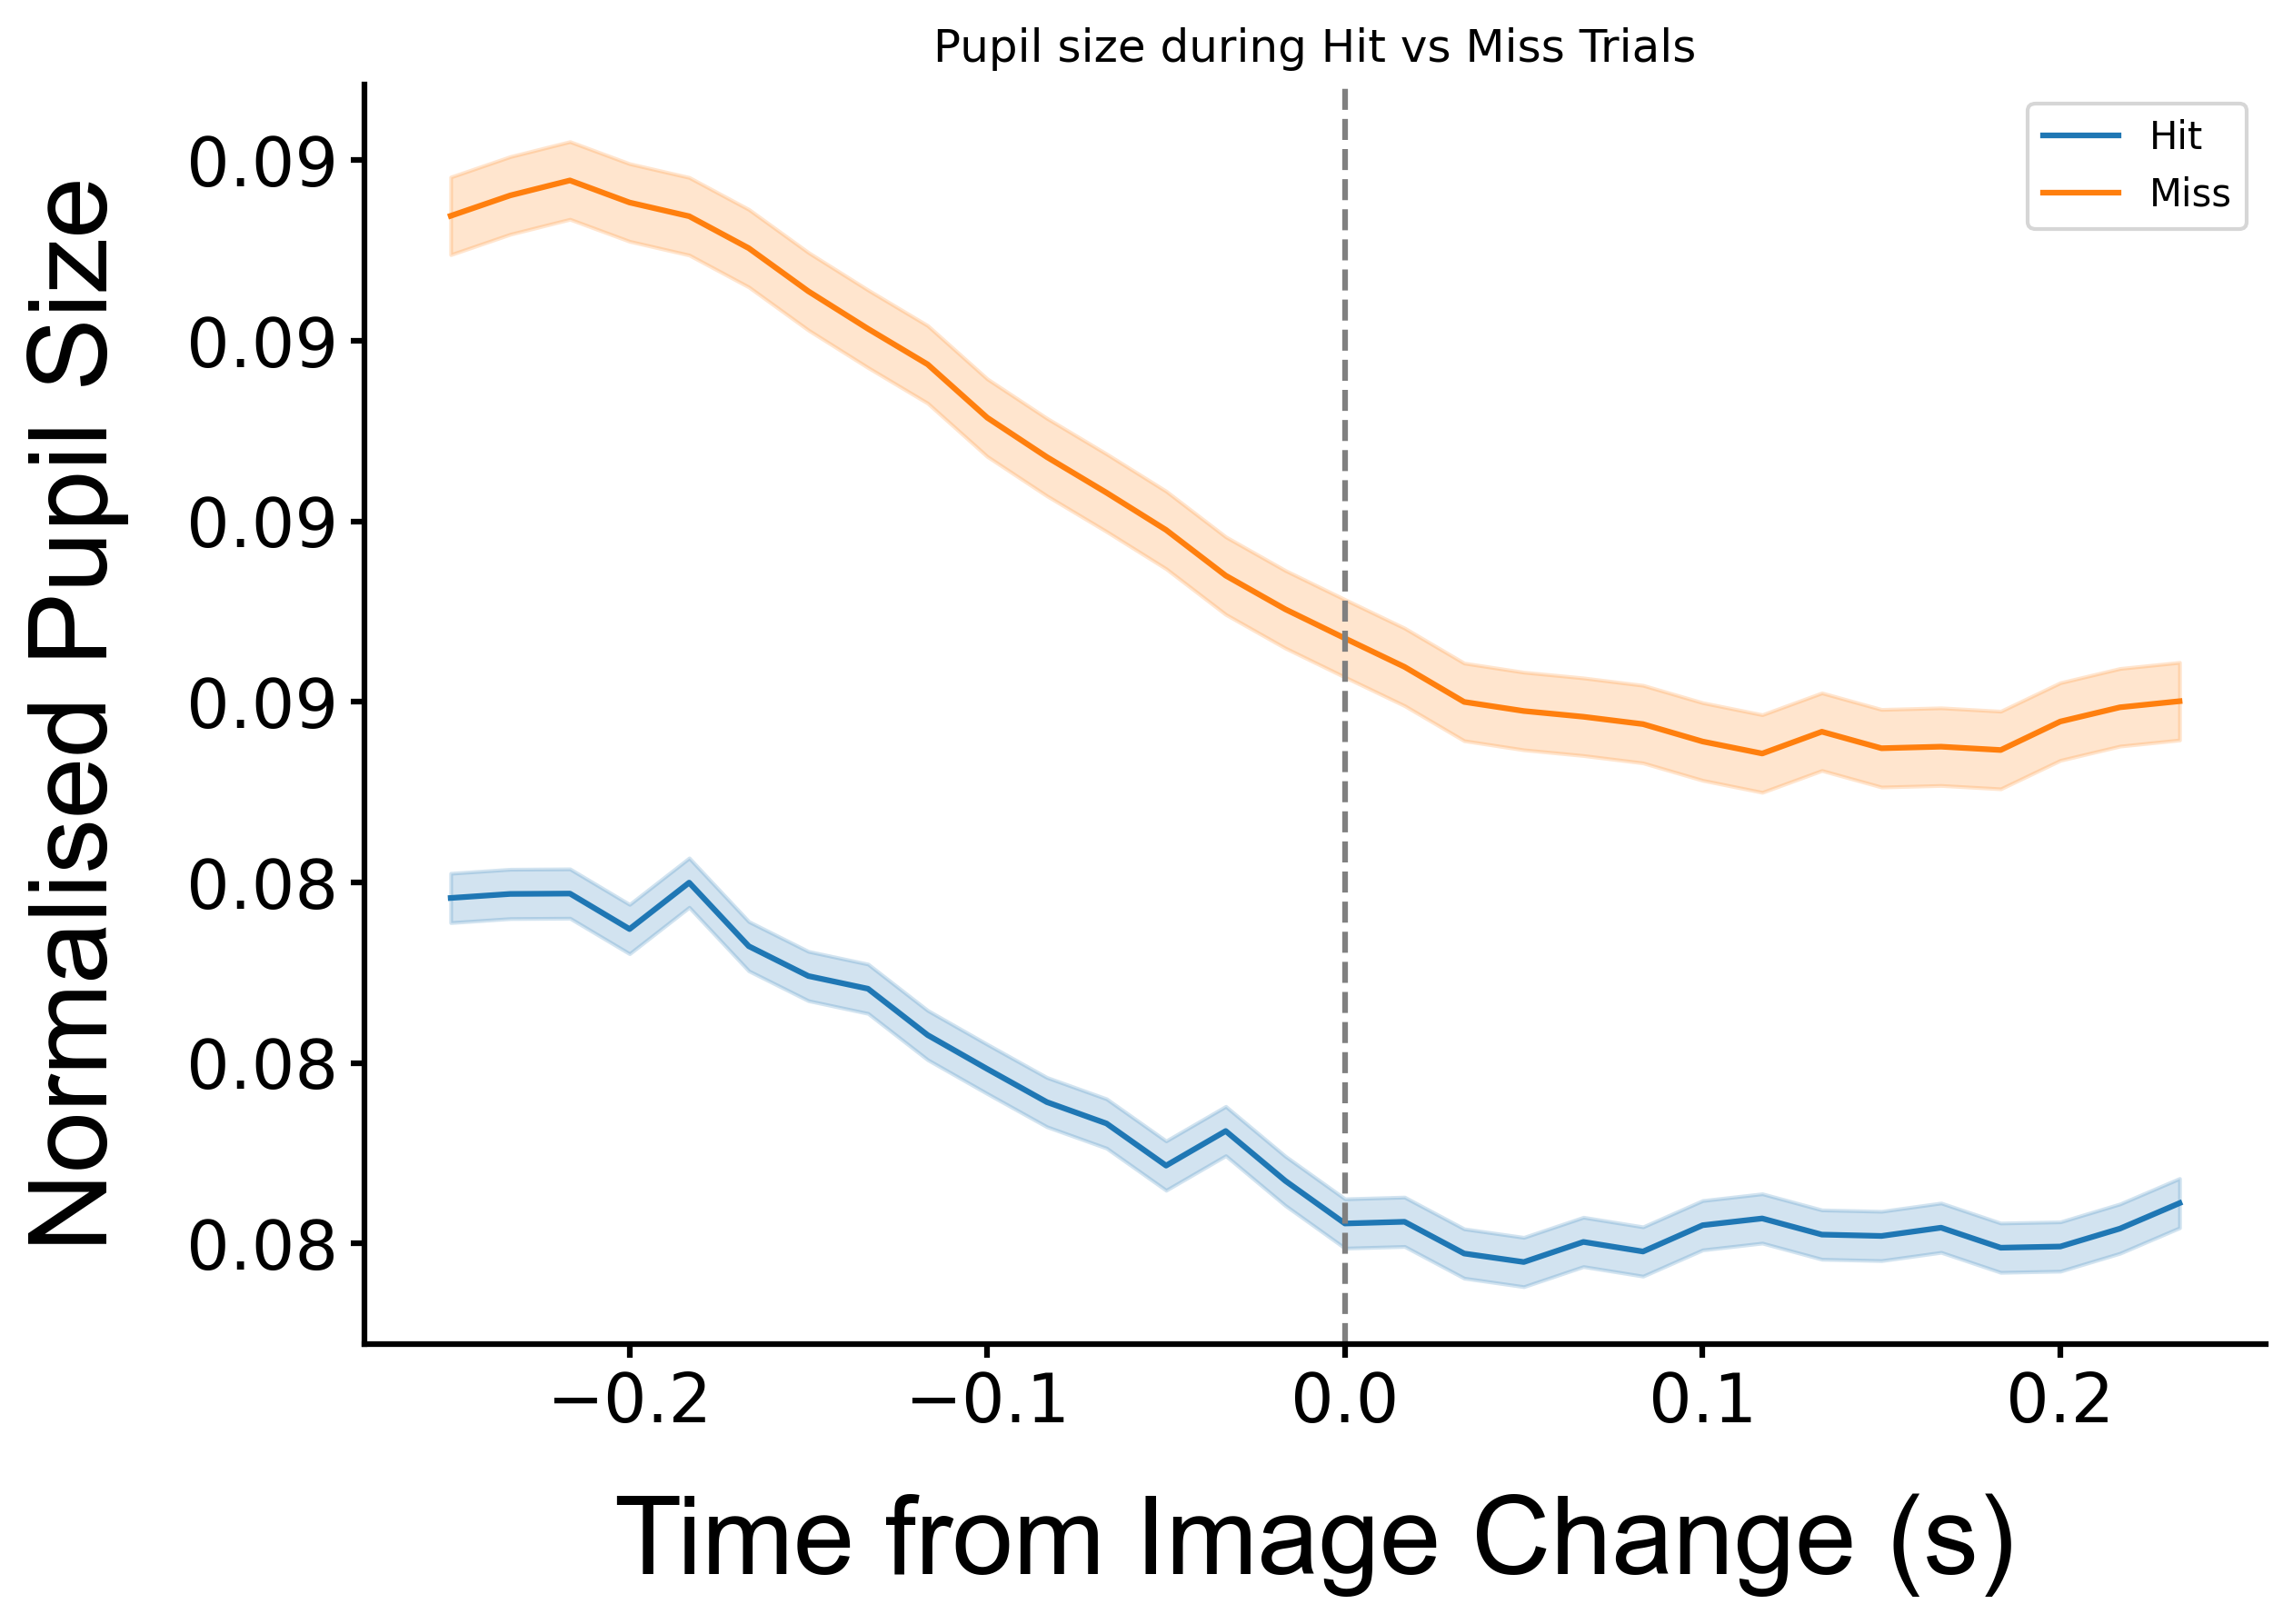

In [20]:
# Pupil size hit vs miss

# Define how many frames worth of data to grab
pre_change_frames = 15  # 0.25s
post_change_frames = 15  # 0.25s
total_frames = 30

# Grab pupil area data (eliminate blinks)
eye_tracking = session.eye_tracking
eye_tracking_noblinks = eye_tracking[~eye_tracking['likely_blink']]

hit_times = hit_trials['change_time_with_display_delay']
miss_times = miss_trials['change_time_with_display_delay']

# Pre-allocate arrays to store stimulus-aligned data
hit_pupil = np.zeros((len(hit_times), total_frames))
miss_pupil = np.zeros((len(miss_times), total_frames))

# Find the maximum pupil area value across the entire session
max_pupil_value = np.max(eye_tracking_noblinks['pupil_area'])

# Loop through image change times for hit trials
for ii, rr in enumerate(hit_times.values):
    pupil_start_ind = np.where(eye_tracking_noblinks['timestamps'] >= rr)[0][0]

    # Check that we aren't trying to grab data indices that don't exist
    if ((pupil_start_ind - pre_change_frames) >= 0) & ((pupil_start_ind + post_change_frames) < len(eye_tracking)):
        trial_data = eye_tracking_noblinks['pupil_area'][pupil_start_ind - pre_change_frames:
                                                        pupil_start_ind + post_change_frames]
        hit_pupil[ii, :] = trial_data
    else:
        hit_pupil[ii, :] = np.nan

# Loop through image change times for miss trials
for ii, rr in enumerate(miss_times.values):
    pupil_start_ind = np.where(eye_tracking_noblinks['timestamps'] >= rr)[0][0]

    # Check that we aren't trying to grab data indices that don't exist
    if ((pupil_start_ind - pre_change_frames) >= 0) & ((pupil_start_ind + post_change_frames) < len(eye_tracking)):
        trial_data = eye_tracking_noblinks['pupil_area'][pupil_start_ind - pre_change_frames:
                                                        pupil_start_ind + post_change_frames]
        miss_pupil[ii, :] = trial_data
    else:
        miss_pupil[ii, :] = np.nan

timevect = np.arange(-pre_change_frames / 60, post_change_frames / 60, 1 / 60)


# Normalize by the overall maximum pupil value
mean_hit_pupil = np.mean(hit_pupil/ max_pupil_value, axis=0)
mean_miss_pupil =  np.mean(miss_pupil/ max_pupil_value, axis=0)

# Calculate standard error of the mean (SEM) for hit and miss trials
group_hit_pupil_sem = np.nanstd(mean_hit_pupil, axis=0, ddof=1) / np.sqrt(len(mean_hit_pupil))
group_miss_pupil_sem = np.nanstd(mean_miss_pupil, axis=0, ddof=1) / np.sqrt(len(mean_miss_pupil))

# Plot mean trace
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(9, 6)


# Plot the mean of interpolated_data over time bins
ax.plot(timevect, mean_hit_pupil, color='#1f77b4', label='Hit')  # blue Hit
ax.plot(timevect, mean_miss_pupil, color='#ff7f0e', label='Miss')  # Orange miss

ax.fill_between(timevect, mean_hit_pupil - group_hit_pupil_sem, mean_hit_pupil + group_hit_pupil_sem, color='#1f77b4', alpha=0.2)
ax.fill_between(timevect, mean_miss_pupil - group_miss_pupil_sem, mean_miss_pupil + group_miss_pupil_sem, color='#ff7f0e', alpha=0.2)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)  # Adjust the width as needed
ax.spines['left'].set_linewidth(1.5)

ax.axvline(x=0, color='grey', linestyle='--')  # Vstim onset with delay
ax.set_title('Pupil size during Hit vs Miss Trials')
ax.set_ylabel('Normalised Pupil Size', labelpad=15, size=29, fontweight=1.5, family='Arial')
ax.set_xlabel('Time from Image Change (s)', labelpad=15, size=29, fontweight=1.5, family='Arial')
ax.tick_params(axis='x', labelsize=18, width=1.5)
ax.tick_params(axis='y', labelsize=18, width=1.5)
ax.legend()

# Define the formatter function for y-axis
def yaxis_formatter(y, pos):
    return f'{y:.2f}'
# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(yaxis_formatter))

from scipy.stats import wilcoxon

# Perform the Wilcoxon signed-rank test on the normalized data
stat, p_value = wilcoxon(mean_hit_pupil, mean_miss_pupil)


# Output the test result
print(f'Wilcoxon signed-rank test statistic: {stat}, p-value: {p_value}')

In [23]:
print(mean_hit_firing_rate)
print(mean_miss_firing_rate)
print(mean_hit_pupil)
print(mean_miss_pupil)

[ 6.19977038  4.47761194  7.00344432  5.85533869  6.4293915   5.62571757
  4.82204363  3.78874856  6.4293915   4.5924225   5.74052813  5.510907
  5.16647532  5.16647532  5.28128588  5.39609644  4.70723307  6.54420207
  5.39609644  3.55912744  4.47761194  5.16647532  5.28128588  5.510907
  4.82204363  5.510907    5.28128588  5.62571757  4.93685419  7.23306544
  8.61079219 13.89207807 13.77726751 16.07347876 13.89207807 15.84385763
 17.10677382 17.22158439 15.84385763 14.35132032 14.69575201 15.38461538
 12.16991963  9.98851894  9.29965557  9.18484501 11.36624569  8.61079219
 10.21814007 10.10332951]
[10.69849691 10.69849691 11.7152962  11.67108753 10.65428824 11.89213086
 10.78691424 10.78691424 11.27320955 11.09637489 10.74270557 11.84792219
 11.31741821 11.05216622 11.45004421 11.5826702  11.40583554 11.22900088
 11.18479222 11.31741821 12.5994695  10.61007958 11.5826702  10.74270557
 12.24580018 10.91954023 10.91954023 11.18479222 11.14058355 11.49425287
 13.08576481 16.79929266 21.7

Pearson correlation coefficient: -0.600438599893165
P-value: 0.00045153789836451555


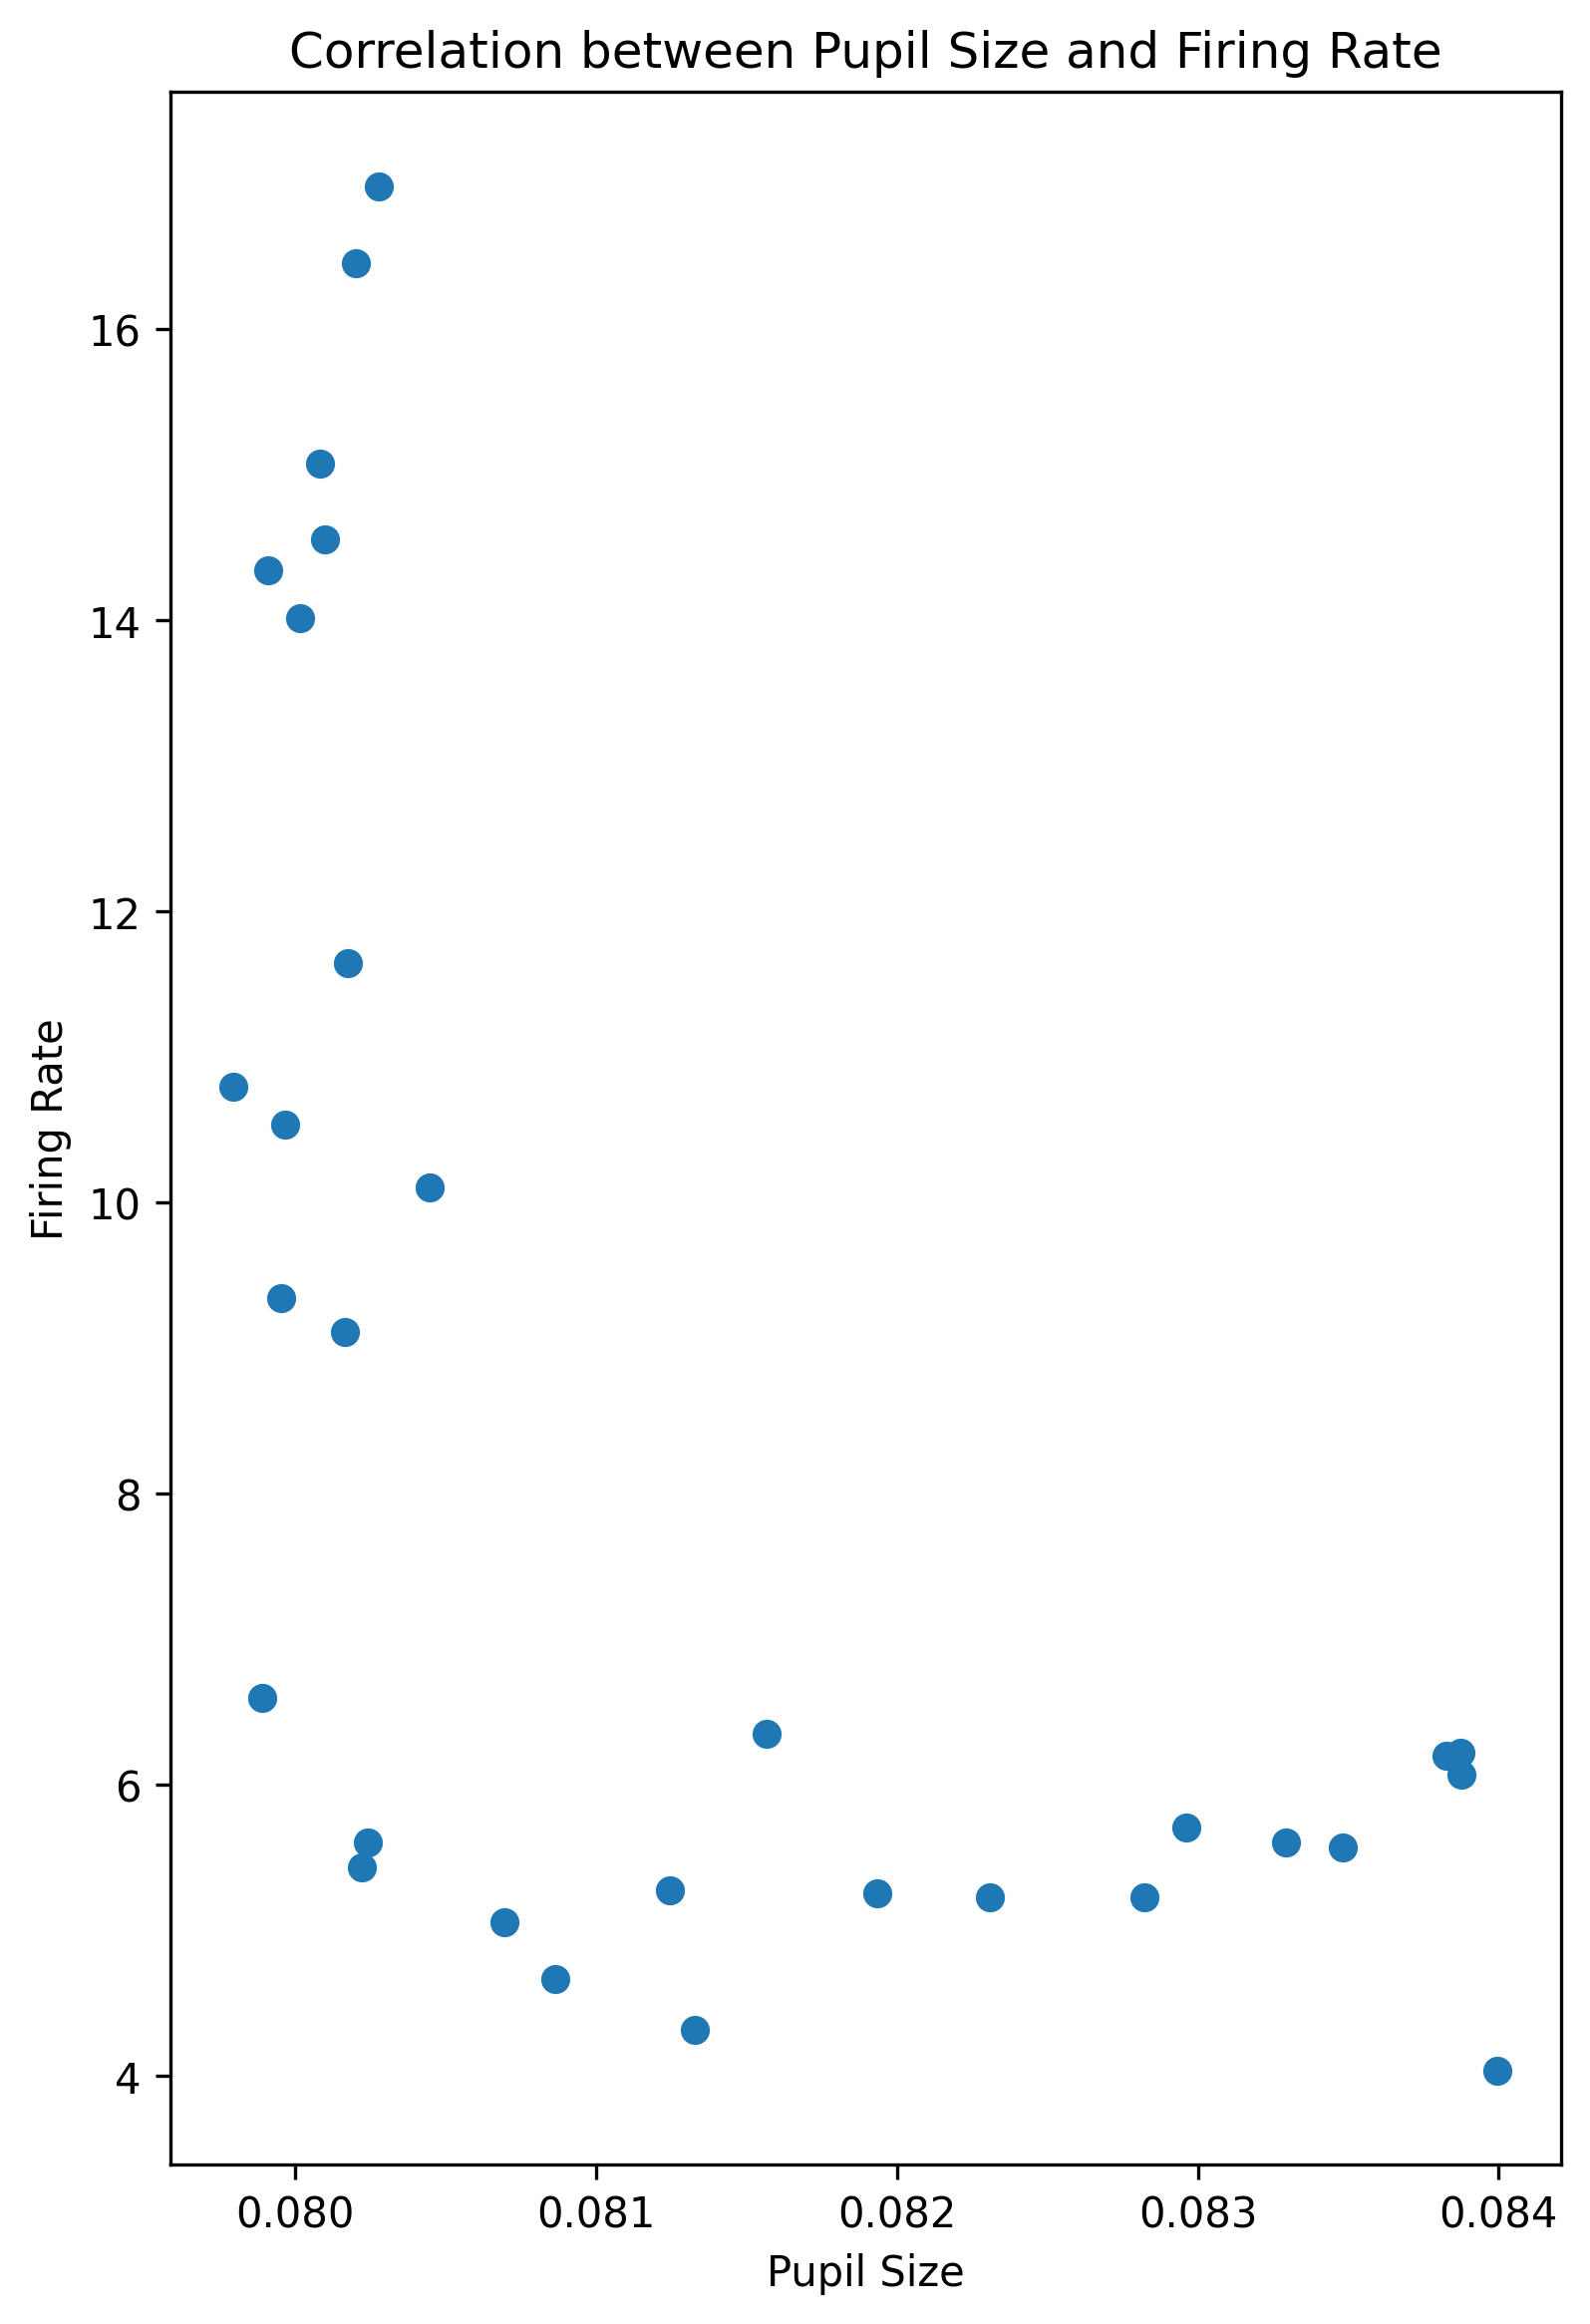

In [27]:
import scipy.stats as stats

# Here we interpolate firing rate to match pupil size
firing_rate_hit_interpolated = np.interp(np.linspace(0, 49, 30), np.arange(50), mean_hit_firing_rate)

# Now compute the correlation
correlation, p_value = stats.pearsonr(mean_hit_pupil, firing_rate_hit_interpolated)

# Print results
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Plot the data and their correlation
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(6, 9)
plt.scatter(mean_hit_pupil, firing_rate_hit_interpolated)
plt.title('Correlation between Pupil Size and Firing Rate')
plt.xlabel('Pupil Size')
plt.ylabel('Firing Rate')
plt.show()

Pearson correlation coefficient: -0.49760172906080447
P-value: 0.005143361803133239


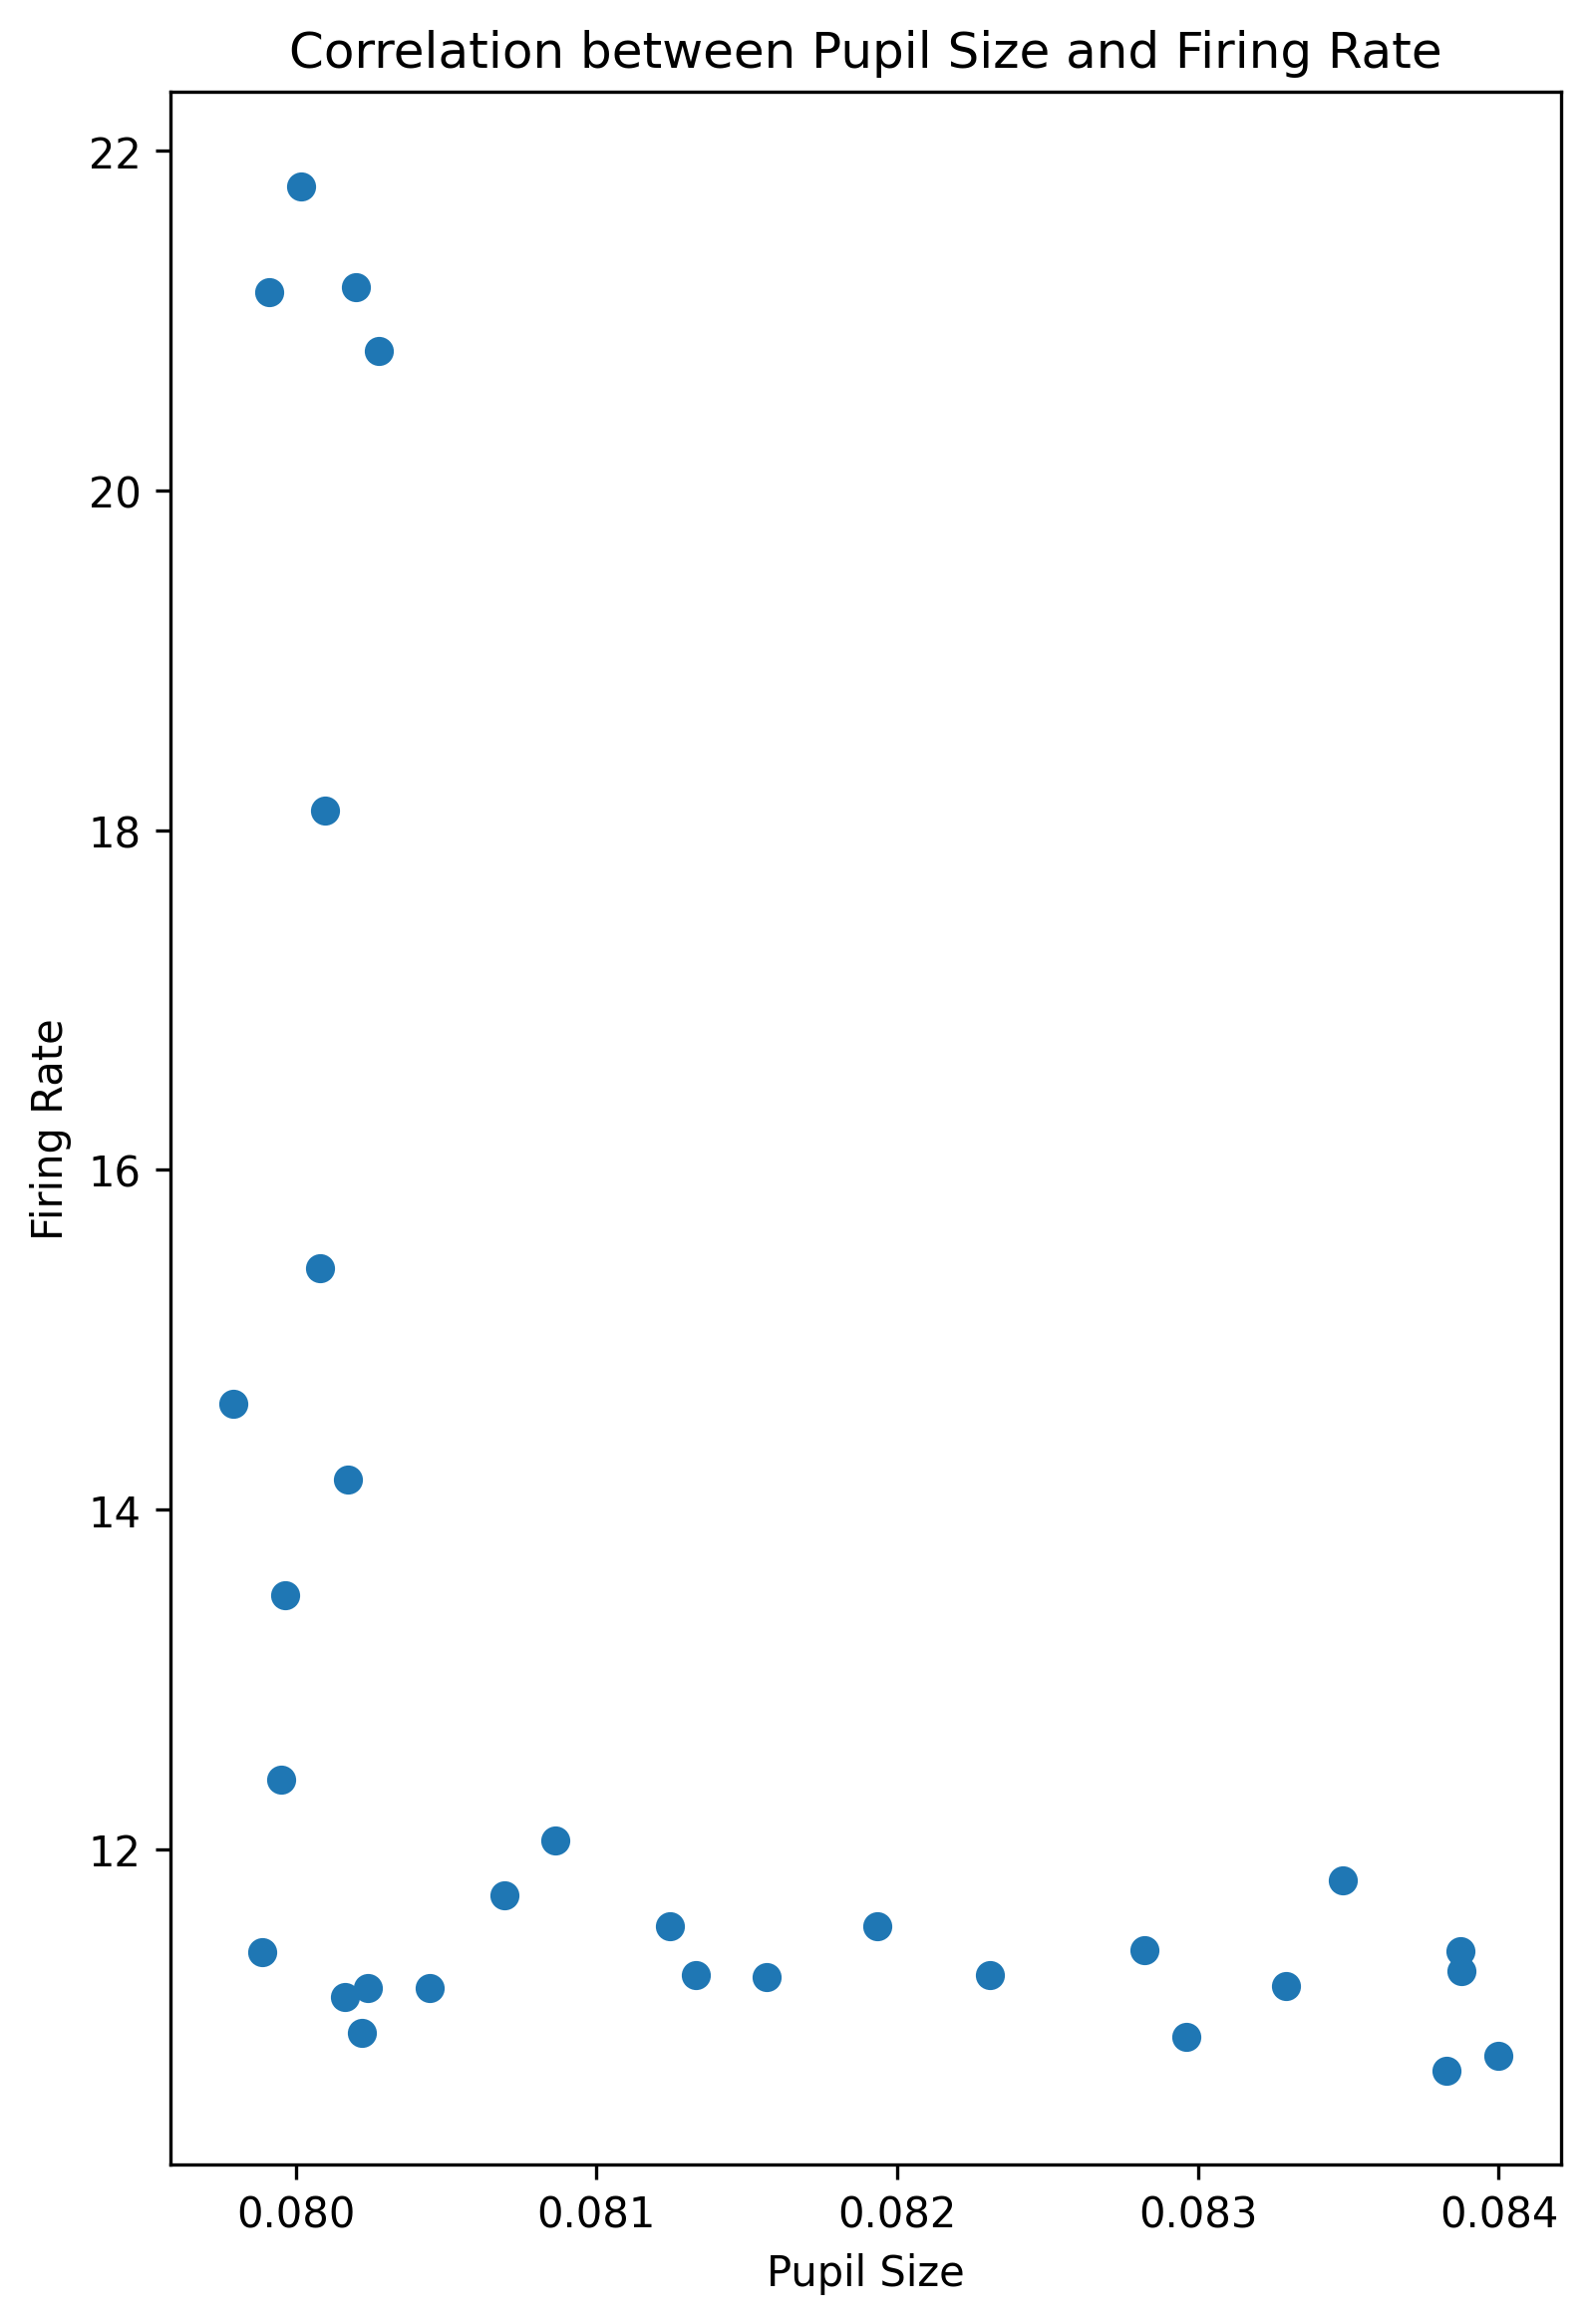

In [28]:
import scipy.stats as stats

# Here we interpolate firing rate to match pupil size
firing_rate_interpolated_miss = np.interp(np.linspace(0, 49, 30), np.arange(50), mean_miss_firing_rate)

# Now compute the correlation
correlation, p_value = stats.pearsonr(mean_hit_pupil, firing_rate_interpolated_miss)

# Print results
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Plot the data and their correlation
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(6, 9)

plt.scatter(mean_hit_pupil, firing_rate_interpolated_miss)
plt.title('Correlation between Pupil Size and Firing Rate')
plt.xlabel('Pupil Size')
plt.ylabel('Firing Rate')
plt.show()